In [179]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols
import sympy as sym
from sympy.solvers.solvers import unrad
from sympy import nroots
from scipy import linalg
import scipy as sci
from scipy import optimize
from scipy import stats
from scipy.interpolate import lagrange
from scipy.optimize import root
from scipy.optimize import minimize
from scipy.optimize import fixed_point
from scipy import odr
from matplotlib import colors as c
import matplotlib.colors as mcolors
import mpmath as mp
import time
import pandas



In [2]:
%matplotlib nbagg
import matplotlib
matplotlib.use('nbagg')
cMap = c.ListedColormap(['r','g','b'])

In [34]:
def hMap(a,b,x,y):
    return 1 - a*x**2 + b*y
    


def backwards_hMap(a,b,x,y):
    return -(1/b)*(1 - a*y**2 - x)
    

def getPeriodic(a,b):
    p1 = (-1*(1 - b) + sym.sqrt((1-b)**2 + 4*a))/(2*a)
    p2 = (-1*(1 - b) - sym.sqrt((1-b)**2 + 4*a))/(2*a)
    return p1,p2

def getUnstableLin(a,b,x):
    evecUn = [-a*x + sym.sqrt(b+a**2 * x**2),1]

    return evecUn

def getStableLin(a,b,x):
    evecSt = [-a*x - sym.sqrt(b+a**2 * x**2),1]
    return evecSt

def getValsMat(M, t0, s0):
    return M.subs([(t,t0),(s,s0)])
def hMap_n(a,b,x,y,n):
    x_i = x
    y_i = y
    
    for i in range(n):
        old_x = x_i
        old_y = y_i
        
        new_x = hMap(a,b,old_x,old_y)
        new_y = old_x
        
        x_i = new_x
        y_i = new_y
        
        if not(np.isfinite(x_i)):
            break
        if np.abs(x_i) > 200 or np.abs(y_i) > 200 :
            
            break
        
    x_n, y_n = x_i,y_i
    return [x_n, y_n]

def hMap_n_counter(a,b,x,y,n,error):
    x_i = x
    y_i = y
    
    converged = False
    my_count = 0
    
    xy_final = hMap_n(a,b,x,y,n)
    for i in range(n):
        
        
        old_x = x_i
        old_y = y_i
        
        new_x = hMap(a,b,old_x,old_y)
        new_y = old_x
        
        
        
        if not(np.isfinite(x_i)):
            break
        if np.abs(x_i) > 200 or np.abs(y_i) > 200 :
            
            break
        if (not converged): 
            my_count += 1
            
        if (not converged) and np.abs(new_x - xy_final[0]) < error and np.abs(new_y - xy_final[1]) < error:
            converged = True
            
        x_i = new_x
        y_i = new_y
        
    x_n, y_n = x_i,y_i
    return [x_n, y_n,my_count]

def NhMap_n(a,b,x,y,n,N):
    x_i,y_i = x,y
    for i in range(N):
        x_i,y_i = hMap_n(a,b,x_i,y_i,n)
    return [x_i,y_i]

def in_set(elem,my_set,error):
    
    for x in my_set:
        if np.abs(elem - x) < error:
            return True
    return False

In [46]:
def get_basins_ofLine(a_i,b_i,xy_0,xy_1,density):
    
    b_val,a_val = b_i,a_i

    
    x_vals,y_vals = np.linspace(xy_0[0],xy_1[0], density),np.linspace(xy_0[1],xy_1[1],density)
    x_f,y_f = np.zeros(density),np.zeros(density)
    basin5_x,basin8_x,basin11_x,basinZ_x =np.zeros(density),np.zeros(density),np.zeros(density),np.zeros(density)
    basin5_y,basin8_y,basin11_y,basinZ_y =np.zeros(density),np.zeros(density),np.zeros(density),np.zeros(density) 
    basin5_iterCount, basin8_iterCount, basin11_iterCount, basinZ_iterCount = np.zeros(density),np.zeros(density),np.zeros(density),np.zeros(density)


    counter = 0
    my_err = 0.01
    a_i,b = a_val,b_val
    counter_5 = 0
    counter_8 = 0
    counter_11 = 0
    
    for i in range(density):
        period_count = 1
        if i % 200 == 0:
            print(i / density * 100)

        xyCount = hMap_n_counter(a_i,b,x_vals[i],y_vals[i],1500,0.001) #image of point after 1500 iterations
        xy = [xyCount[0], xyCount[1]]
        my_count = xyCount[2]
        #check if diverged, if so then set to white (NaN) and skip
        if (np.isnan(xy[0]) or (np.abs(xy[0])>200) or (np.abs(xy[1]) > 200)):
            x_f[i],y_f[i] = np.NaN,np.NaN
            #print('skipped')
            continue
        
        #print(xy) 
            
        returned = False
        xy_new = hMap_n(a_i,b,xy[0],xy[1],1)
        while(not returned):
            
            if  np.abs(xy_new[0] - xy[0]) > my_err and np.abs(xy_new[1] - xy[1]) > my_err: 
                period_count+=1
                xy_new = hMap_n(a_i,b,xy_new[0],xy_new[1],1)
                #print(xy_new)
                    
            else: returned = True
        
        #now we know period of orbit
        x_f[i],y_f[i] = period_count,period_count
        
        if period_count == 5:
            basin5_x[counter_5] = x_vals[i]
            basin5_y[counter_5] = y_vals[i]
            basin5_iterCount[counter_5] = my_count
            counter_5 += 1
        
        if period_count == 8:
            basin8_x[counter_8] = x_vals[i]
            basin8_y[counter_8] = y_vals[i]
            basin8_iterCount[counter_8] = my_count
            counter_8 += 1
        
        if period_count == 11:
            basin11_x[counter_11] = x_vals[i]
            basin11_y[counter_11] = y_vals[i]
            basin11_iterCount[counter_11] = my_count
            counter_11 += 1
        
        
        x_f[i],y_f[i] = period_count,period_count
        if not in_set(period_count, [5,8,11], 0.1):
            print(period_count)
            print(xy)
            print('!!!!!!!!')
            print("Found another period")
            print('------------------------------------------------------------------')
            print(xy)
            
            
    #compress basin5,8,11 info
    basin5_data = [basin5_x[0:counter_5],basin5_y[0:counter_5],basin5_iterCount[0:counter_5]]
    basin8_data = [basin8_x[0:counter_8],basin8_y[0:counter_8],basin8_iterCount[0:counter_8]]
    basin11_data = [basin11_x[0:counter_11],basin11_y[0:counter_11],basin11_iterCount[0:counter_11]]
    basin_data = [basin5_data,basin8_data,basin11_data,x_f]
    
    
    return basin_data



In [82]:
density = 100000
myBasinData = get_basins_ofLine( 2.2534022522522523,-0.43206301601601604,[0.738513439884581,0],[0.7415680180549339,0],density)


0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.200000000000003
20.4
20.599999999999998
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.200000000000003
23.400000000000002
23

In [83]:
basin11_data = myBasinData[2]
basin11_x,basin11_y,basin11_iterCount = basin11_data[0],basin11_data[1],basin11_data[2]

basin8_data = myBasinData[1]
basin8_x,basin8_y,basin8_iterCount = basin8_data[0],basin8_data[1],basin8_data[2]

basin5_data = myBasinData[0]
basin5_x,basin5_y,basin5_iterCount = basin5_data[0],basin5_data[1],basin5_data[2]

my_x_f = myBasinData[3]

In [91]:
L_5_points,L_8_points,L_11_points = np.zeros(density),np.zeros(density),np.zeros(density)

counter_5,counter_8,counter_11 = 0,0,0
for i in range(density):
    
    
    if my_x_f[i] == 5:
        L_5_points[i] = basin5_iterCount[counter_5]
        counter_5 += 1
        
    if my_x_f[i] == 8:
        L_8_points[i] = basin8_iterCount[counter_8]
        counter_8 += 1    
        
    if my_x_f[i] == 11:
        L_11_points[i] = basin11_iterCount[counter_11]
        counter_11 += 1 

L_5_points[ L_5_points==0 ] = np.nan
L_8_points[ L_8_points==0 ] = np.nan
L_11_points[ L_11_points==0 ] = np.nan

<IPython.core.display.Javascript object>


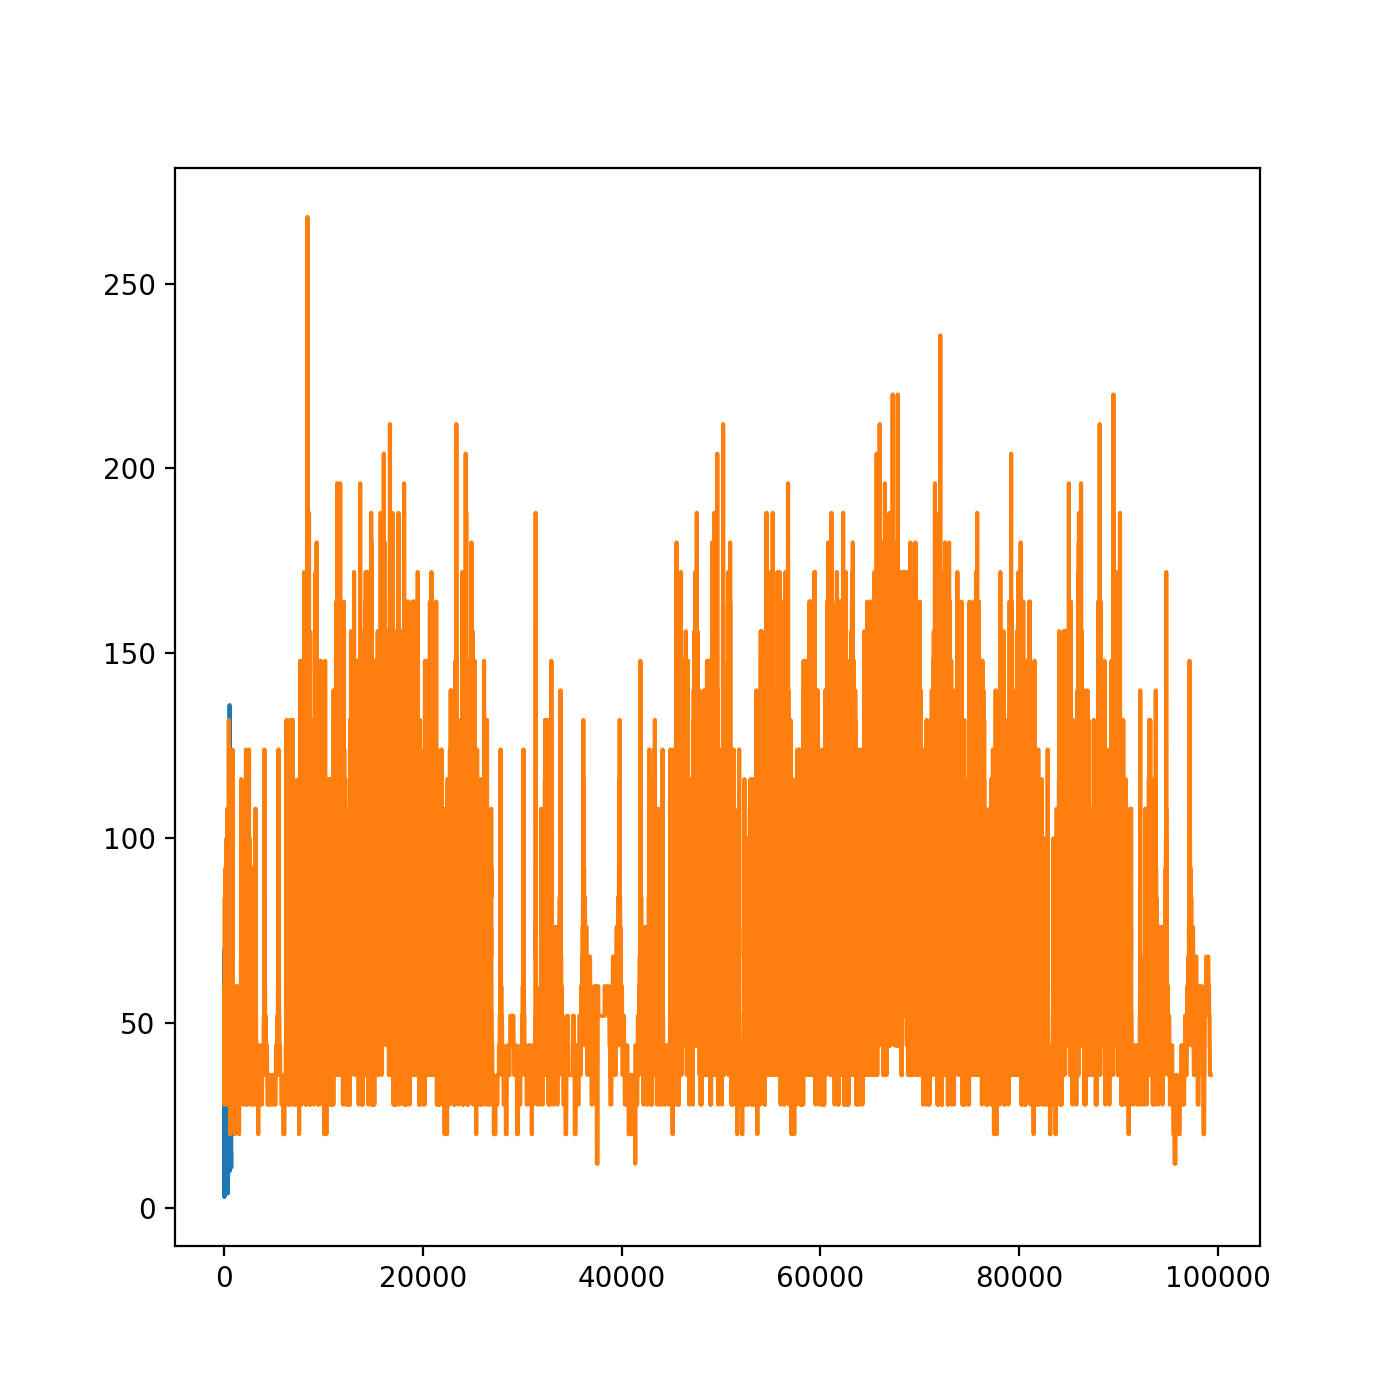

In [92]:
#cMap = c.ListedColormap(['g','pink','r'])
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1,1,1)
plt.plot(range(len(basin11_x)),basin11_iterCount)
plt.plot(range(len(basin8_x)),basin8_iterCount)
plt.plot(range(len(basin5_x)),basin5_iterCount)
plt.show()

<IPython.core.display.Javascript object>


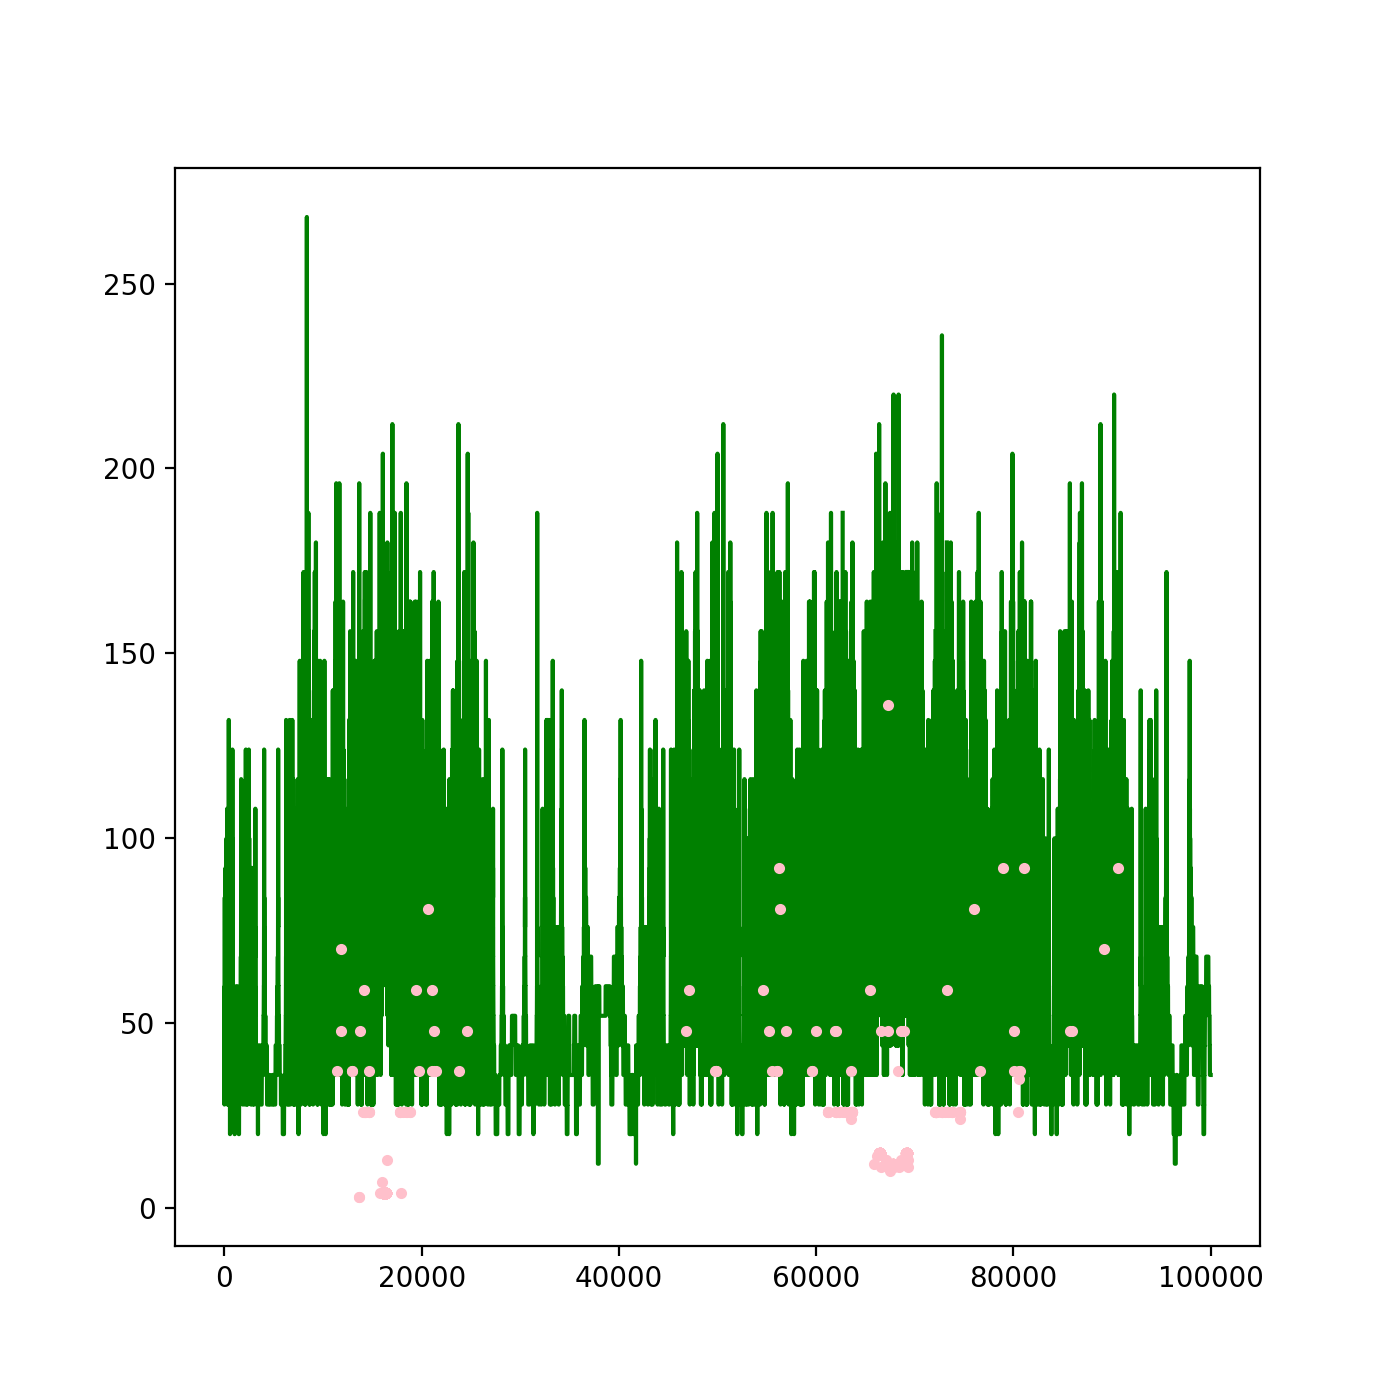

In [96]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1,1,1)

plt.plot(range(density),L_8_points,'-',color='green')
plt.plot(range(density),L_11_points,'.',color='pink')

plt.plot(range(density),L_5_points,color='red')



In [97]:
density = 500000
myBasinData = get_basins_ofLine( 2.2534022522522523,-0.43206301601601604,[0,0],[1,0],density)



0.0
0.04
0.08
0.12
0.16
0.2
0.24
0.27999999999999997
0.32
0.36
0.4
0.44
0.48
0.52
0.5599999999999999
0.6
0.64
0.6799999999999999
0.72
0.76
0.8
0.84
0.88
0.9199999999999999
0.96
1.0
1.04
1.08
1.1199999999999999
1.16
1.2
1.24
1.28
1.32
1.3599999999999999
1.4000000000000001
1.44
1.48
1.52
1.5599999999999998
1.6
1.6400000000000001
1.68
1.72
1.76
1.7999999999999998
1.8399999999999999
1.8800000000000001
1.92
1.96
2.0
2.04
2.08
2.12
2.16
2.1999999999999997
2.2399999999999998
2.2800000000000002
2.32
2.36
2.4
2.44
2.48
2.52
2.56
2.6
2.64
2.68
2.7199999999999998
2.76
2.8000000000000003
2.8400000000000003
2.88
2.92
2.96
3.0
3.04
3.08
3.1199999999999997
3.16
3.2
3.2399999999999998
3.2800000000000002
3.32
3.36
3.4000000000000004
3.44
3.4799999999999995
3.52
3.56
3.5999999999999996
3.64
3.6799999999999997
3.7199999999999998
3.7600000000000002
3.8
3.84
3.88
3.92
3.9600000000000004
4.0
4.04
4.08
4.12
4.16
4.2
4.24
4.279999999999999
4.32
4.36
4.3999999999999995
4.44
4.4799999999999995
4.52
4.5600000000

35.28
35.32
35.36
35.4
35.44
35.480000000000004
35.52
35.56
35.6
35.64
35.68
35.72
35.76
35.8
35.839999999999996
35.88
35.92
35.96
36.0
36.04
36.08
36.120000000000005
36.16
36.199999999999996
36.24
36.28
36.32
36.36
36.4
36.44
36.480000000000004
36.52
36.559999999999995
36.6
36.64
36.68
36.720000000000006
36.76
36.8
36.84
36.88
36.919999999999995
36.96
37.0
37.04
37.08
37.12
37.16
37.2
37.24
37.28
37.32
37.36
37.4
37.44
37.480000000000004
37.519999999999996
37.56
37.6
37.64
37.68
37.72
37.76
37.8
37.84
37.88
37.92
37.96
38.0
38.04
38.080000000000005
38.12
38.16
38.2
38.24
38.279999999999994
38.32
38.36
38.4
38.440000000000005
38.48
38.519999999999996
38.56
38.6
38.64
38.68
38.72
38.76
38.800000000000004
38.84
38.879999999999995
38.92
38.96
39.0
39.04
39.08
39.12
39.160000000000004
39.2
39.24
39.28
39.32
39.36
39.4
39.44
39.48
39.519999999999996
39.56
39.6
39.64
39.68
39.72
39.76
39.800000000000004
39.839999999999996
39.879999999999995
39.92
39.96
40.0
40.04
40.08
40.12
40.1600000000000

70.28
70.32000000000001
70.36
70.39999999999999
70.44
70.48
70.52000000000001
70.56
70.6
70.64
70.67999999999999
70.72
70.76
70.8
70.84
70.88
70.92
70.96000000000001
71.0
71.04
71.08
71.12
71.16
71.2
71.24000000000001
71.28
71.32
71.36
71.39999999999999
71.44
71.48
71.52
71.56
71.6
71.64
71.67999999999999
71.72
71.76
71.8
71.84
71.88
71.92
71.96000000000001
72.0
72.04
72.08
72.11999999999999
72.16
72.2
72.24000000000001
72.28
72.32
72.36
72.39999999999999
72.44
72.48
72.52
72.56
72.6
72.64
72.68
72.72
72.76
72.8
72.84
72.88
72.92
72.96000000000001
73.0
73.04
73.08
73.11999999999999
73.16
73.2
73.24000000000001
73.28
73.32
73.36
73.4
73.44000000000001
73.48
73.52
73.56
73.6
73.64
73.68
73.72
73.76
73.8
73.83999999999999
73.88
73.92
73.96000000000001
74.0
74.03999999999999
74.08
74.11999999999999
74.16
74.2
74.24
74.28
74.32
74.36
74.4
74.44
74.48
74.52
74.56
74.6
74.64
74.68
74.72
74.76
74.8
74.83999999999999
74.88
74.92
74.96000000000001
75.0
75.03999999999999
75.08
75.12
75.1600000000

In [101]:
basin11_data = myBasinData[2]
basin11_x,basin11_y,basin11_iterCount = basin11_data[0],basin11_data[1],basin11_data[2]

basin8_data = myBasinData[1]
basin8_x,basin8_y,basin8_iterCount = basin8_data[0],basin8_data[1],basin8_data[2]

basin5_data = myBasinData[0]
basin5_x,basin5_y,basin5_iterCount = basin5_data[0],basin5_data[1],basin5_data[2]

my_x_f = myBasinData[3]

L_5_points,L_8_points,L_11_points = np.zeros(density),np.zeros(density),np.zeros(density)

counter_5,counter_8,counter_11 = 0,0,0
for i in range(density):
    
    
    if my_x_f[i] == 5:
        L_5_points[i] = basin5_iterCount[counter_5]
        counter_5 += 1
        
    if my_x_f[i] == 8:
        L_8_points[i] = basin8_iterCount[counter_8]
        counter_8 += 1    
        
    if my_x_f[i] == 11:
        L_11_points[i] = basin11_iterCount[counter_11]
        counter_11 += 1 

L_5_points[ L_5_points==0 ] = np.nan
L_8_points[ L_8_points==0 ] = np.nan
L_11_points[ L_11_points==0 ] = np.nan



<IPython.core.display.Javascript object>


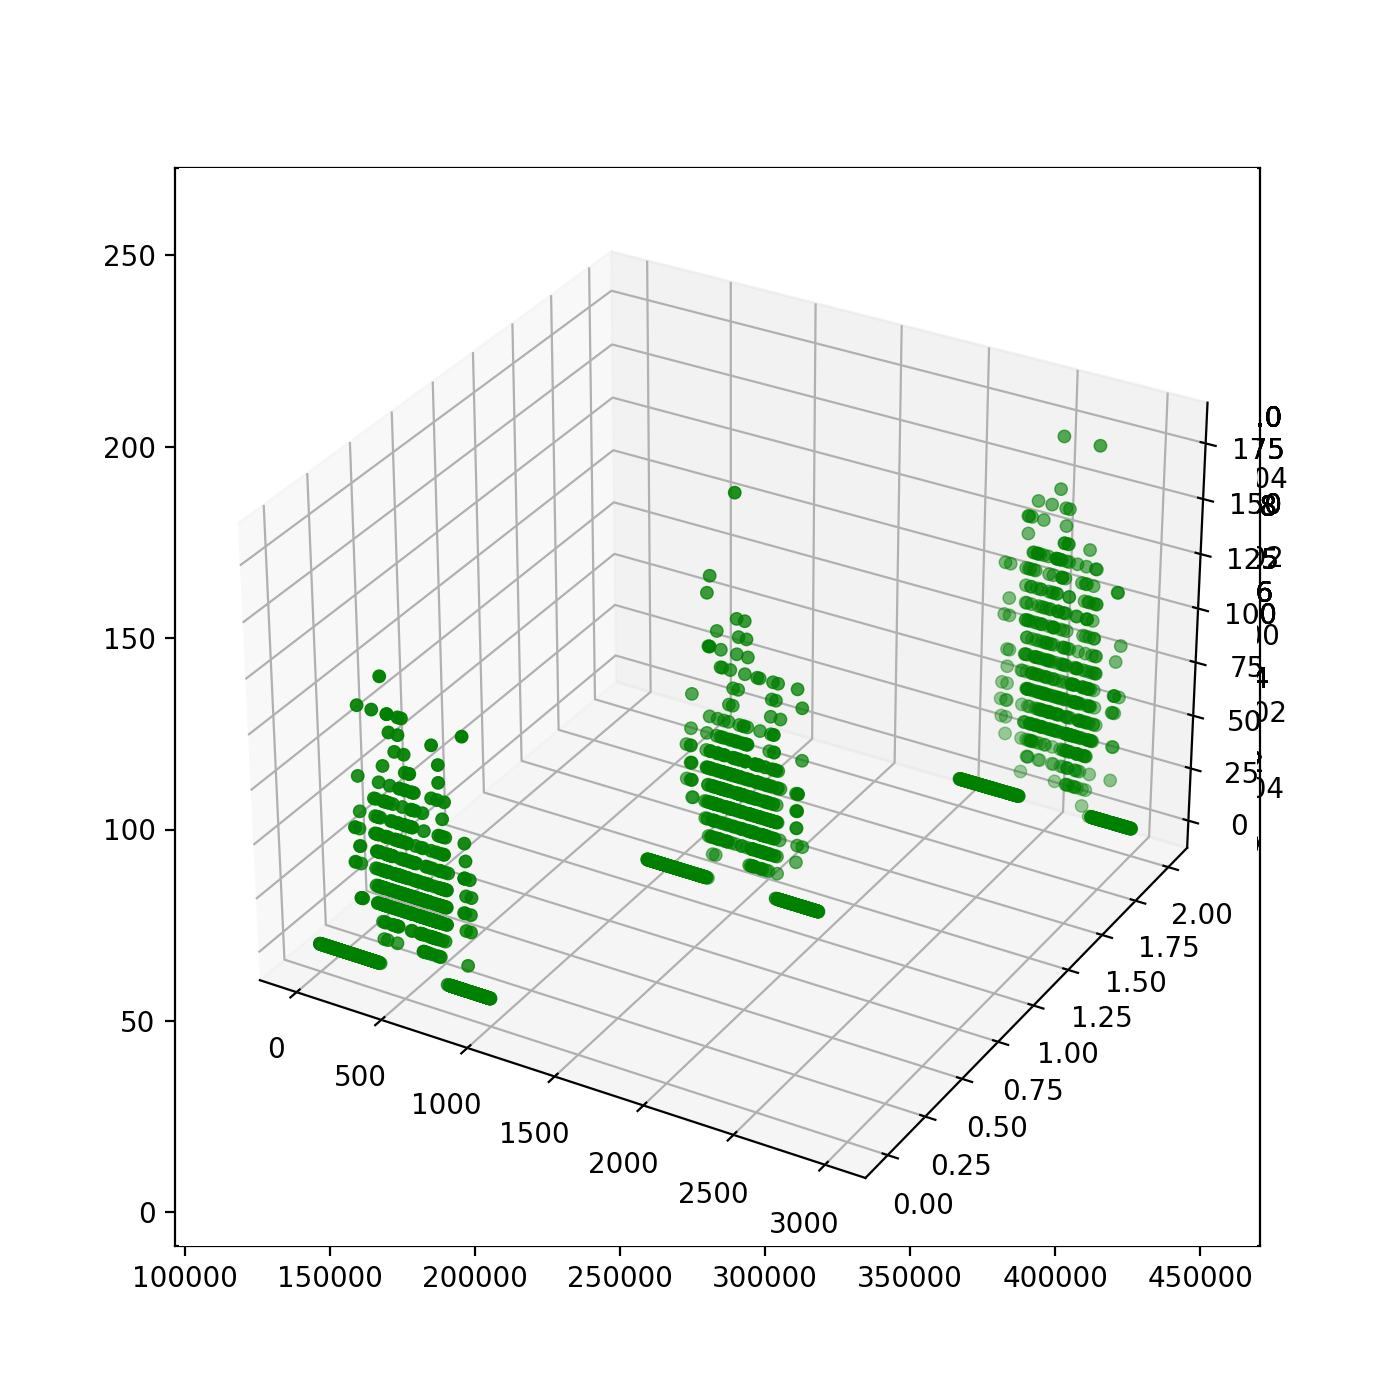

In [109]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1,1,1)

plt.plot(range(density),L_8_points,'-',color='green')
plt.plot(range(density),L_11_points,'.',color='pink')

plt.plot(range(density),L_5_points,'.',color='red')



In [155]:
par_dens = 100
b_train = np.linspace(-0.436399,-0.430103,par_dens)
a_train = np.linspace(2.26115,2.2499,par_dens)


x_f_list = []
start = time.time()


x_bot_left = 0.7646997056380808
x_bot_right = 0.765261173434333


x_top_left =0.7677052097239015
x_top_right =  0.7682666775201539
x_left = np.linspace(x_bot_left,x_top_left,par_dens)
x_right = np.linspace(x_bot_right,x_top_right,par_dens)

density = 100000

list_5_vals2 = np.zeros(par_dens)
list_8_vals2 = np.zeros(par_dens)
list_11_vals2 = np.zeros(par_dens)

# z_i = (L_i, iter_count_i, (b,a)_i) 
z_par = np.zeros(par_dens*density+1)

z5_Li = np.zeros(par_dens*density+1)
z5_iter = np.zeros(par_dens*density+1)


z8_Li = np.zeros(par_dens*density+1)
z8_iter = np.zeros(par_dens*density+1)

z11_Li = np.zeros(par_dens*density+1)
z11_iter = np.zeros(par_dens*density+1)

total_iteration_num = 0
for j in range(par_dens):
    
    
    myBasinData = get_basins_ofLine( a_train[j],b_train[j],[x_left[j],0],[x_right[j],0],density)
    
    
    

    #x_f_list.append(x_f_i)
    print(j,': ',(time.time()-start)/60,' min')


    basin11_data = myBasinData[2]
    basin11_x,basin11_y,basin11_iterCount = basin11_data[0],basin11_data[1],basin11_data[2]

    basin8_data = myBasinData[1]
    basin8_x,basin8_y,basin8_iterCount = basin8_data[0],basin8_data[1],basin8_data[2]

    basin5_data = myBasinData[0]
    basin5_x,basin5_y,basin5_iterCount = basin5_data[0],basin5_data[1],basin5_data[2]

    my_x_f = myBasinData[3]

    L_5_points,L_8_points,L_11_points = np.zeros(density),np.zeros(density),np.zeros(density)

    counter_5,counter_8,counter_11 = 0,0,0
    
    for i in range(density):
        total_iteration_num += 1
        
        z_par[total_iteration_num] = j
        

        if my_x_f[i] == 5:
            L_5_points[i] = basin5_iterCount[counter_5]
            
            z5_Li[total_iteration_num] = total_iteration_num
            z5_iter[total_iteration_num] = basin5_iterCount[counter_5]
            
            counter_5 += 1

        if my_x_f[i] == 8:
            L_8_points[i] = basin8_iterCount[counter_8]
            
            z8_Li[total_iteration_num] = total_iteration_num
            z8_iter[total_iteration_num] = basin8_iterCount[counter_8]
            
            counter_8 += 1    

        if my_x_f[i] == 11:
            L_11_points[i] = basin11_iterCount[counter_11]
            
            z11_Li[total_iteration_num] = total_iteration_num
            z11_iter[total_iteration_num] = basin11_iterCount[counter_11]
            
            counter_11 += 1 

    L_5_points[ L_5_points ==0 ] = np.nan
    L_8_points[ L_8_points ==0 ] = np.nan
    L_11_points[ L_11_points ==0 ] = np.nan
    
    


0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.200000000000003
20.4
20.599999999999998
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.200000000000003
23.400000000000002
23

96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
1 :  7.864482001463572  min
0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.

93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.39999999999999
94.6
94.8
95.0
95.19999999999999
95.39999999999999
95.6
95.8
96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
3 :  15.734558697541555  min
0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.4

89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91.8
92.0
92.2
92.4
92.60000000000001
92.80000000000001
93.0
93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.39999999999999
94.6
94.8
95.0
95.19999999999999
95.39999999999999
95.6
95.8
96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
5 :  23.578764184316  min
0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12

83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91.8
92.0
92.2
92.4
92.60000000000001
92.80000000000001
93.0
93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.39999999999999
94.6
94.8
95.0
95.19999999999999
95.39999999999999
95.6
95.8
96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
7 :  31.412987033526104  min
0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6

79.2
79.4
79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000000000001
80.80000000000001
81.0
81.2
81.39999999999999
81.6
81.8
82.0
82.19999999999999
82.39999999999999
82.6
82.8
83.0
83.2
83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91.8
92.0
92.2
92.4
92.60000000000001
92.80000000000001
93.0
93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.39999999999999
94.6
94.8
95.0
95.19999999999999
95.39999999999999
95.6
95.8
96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
9 :  39.15835499763489  min
0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996


72.6
72.8
73.0
73.2
73.4
73.6
73.8
74.0
74.2
74.4
74.6
74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0
77.2
77.4
77.60000000000001
77.8
78.0
78.2
78.4
78.60000000000001
78.8
79.0
79.2
79.4
79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000000000001
80.80000000000001
81.0
81.2
81.39999999999999
81.6
81.8
82.0
82.19999999999999
82.39999999999999
82.6
82.8
83.0
83.2
83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91.8
92.0
92.2
92.4
92.60000000000001
92.80000000000001
93.0
93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.39999999999999
94.6
94.8
95.0
95.19999999999999
95.39999999999999
95.6
95.8
96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
11 

68.4
68.60000000000001
68.8
69.0
69.19999999999999
69.39999999999999
69.6
69.8
70.0
70.19999999999999
70.39999999999999
70.6
70.8
71.0
71.2
71.39999999999999
71.6
71.8
72.0
72.2
72.39999999999999
72.6
72.8
73.0
73.2
73.4
73.6
73.8
74.0
74.2
74.4
74.6
74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0
77.2
77.4
77.60000000000001
77.8
78.0
78.2
78.4
78.60000000000001
78.8
79.0
79.2
79.4
79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000000000001
80.80000000000001
81.0
81.2
81.39999999999999
81.6
81.8
82.0
82.19999999999999
82.39999999999999
82.6
82.8
83.0
83.2
83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91.8
92.0
92.2
92.4
92.60000000000001
92.80000000000001
93.0
93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.399999999

65.4
65.60000000000001
65.8
66.0
66.2
66.4
66.60000000000001
66.8
67.0
67.2
67.4
67.60000000000001
67.80000000000001
68.0
68.2
68.4
68.60000000000001
68.8
69.0
69.19999999999999
69.39999999999999
69.6
69.8
70.0
70.19999999999999
70.39999999999999
70.6
70.8
71.0
71.2
71.39999999999999
71.6
71.8
72.0
72.2
72.39999999999999
72.6
72.8
73.0
73.2
73.4
73.6
73.8
74.0
74.2
74.4
74.6
74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0
77.2
77.4
77.60000000000001
77.8
78.0
78.2
78.4
78.60000000000001
78.8
79.0
79.2
79.4
79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000000000001
80.80000000000001
81.0
81.2
81.39999999999999
81.6
81.8
82.0
82.19999999999999
82.39999999999999
82.6
82.8
83.0
83.2
83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91

60.6
60.8
61.0
61.199999999999996
61.4
61.6
61.8
62.0
62.2
62.4
62.6
62.8
63.0
63.2
63.4
63.6
63.800000000000004
64.0
64.2
64.4
64.60000000000001
64.8
65.0
65.2
65.4
65.60000000000001
65.8
66.0
66.2
66.4
66.60000000000001
66.8
67.0
67.2
67.4
67.60000000000001
67.80000000000001
68.0
68.2
68.4
68.60000000000001
68.8
69.0
69.19999999999999
69.39999999999999
69.6
69.8
70.0
70.19999999999999
70.39999999999999
70.6
70.8
71.0
71.2
71.39999999999999
71.6
71.8
72.0
72.2
72.39999999999999
72.6
72.8
73.0
73.2
73.4
73.6
73.8
74.0
74.2
74.4
74.6
74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0
77.2
77.4
77.60000000000001
77.8
78.0
78.2
78.4
78.60000000000001
78.8
79.0
79.2
79.4
79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000000000001
80.80000000000001
81.0
81.2
81.39999999999999
81.6
81.8
82.0
82.19999999999999
82.39999999999999
82.6
82.8
83.0
83.2
83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8


57.4
57.599999999999994
57.8
57.99999999999999
58.199999999999996
58.4
58.599999999999994
58.8
59.0
59.199999999999996
59.4
59.599999999999994
59.8
60.0
60.199999999999996
60.4
60.6
60.8
61.0
61.199999999999996
61.4
61.6
61.8
62.0
62.2
62.4
62.6
62.8
63.0
63.2
63.4
63.6
63.800000000000004
64.0
64.2
64.4
64.60000000000001
64.8
65.0
65.2
65.4
65.60000000000001
65.8
66.0
66.2
66.4
66.60000000000001
66.8
67.0
67.2
67.4
67.60000000000001
67.80000000000001
68.0
68.2
68.4
68.60000000000001
68.8
69.0
69.19999999999999
69.39999999999999
69.6
69.8
70.0
70.19999999999999
70.39999999999999
70.6
70.8
71.0
71.2
71.39999999999999
71.6
71.8
72.0
72.2
72.39999999999999
72.6
72.8
73.0
73.2
73.4
73.6
73.8
74.0
74.2
74.4
74.6
74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0
77.2
77.4
77.60000000000001
77.8
78.0
78.2
78.4
78.60000000000001
78.8
79.0
79.2
79.4
79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000000000001
80.80000000000001
81.0
81.2
81.39999999999999
81.6
81.8
82.0
82.19999

56.39999999999999
56.599999999999994
56.8
56.99999999999999
57.199999999999996
57.4
57.599999999999994
57.8
57.99999999999999
58.199999999999996
58.4
58.599999999999994
58.8
59.0
59.199999999999996
59.4
59.599999999999994
59.8
60.0
60.199999999999996
60.4
60.6
60.8
61.0
61.199999999999996
61.4
61.6
61.8
62.0
62.2
62.4
62.6
62.8
63.0
63.2
63.4
63.6
63.800000000000004
64.0
64.2
64.4
64.60000000000001
64.8
65.0
65.2
65.4
65.60000000000001
65.8
66.0
66.2
66.4
66.60000000000001
66.8
67.0
67.2
67.4
67.60000000000001
67.80000000000001
68.0
68.2
68.4
68.60000000000001
68.8
69.0
69.19999999999999
69.39999999999999
69.6
69.8
70.0
70.19999999999999
70.39999999999999
70.6
70.8
71.0
71.2
71.39999999999999
71.6
71.8
72.0
72.2
72.39999999999999
72.6
72.8
73.0
73.2
73.4
73.6
73.8
74.0
74.2
74.4
74.6
74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0
77.2
77.4
77.60000000000001
77.8
78.0
78.2
78.4
78.60000000000001
78.8
79.0
79.2
79.4
79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000

54.6
54.800000000000004
55.00000000000001
55.2
55.400000000000006
55.60000000000001
55.800000000000004
56.00000000000001
56.2
56.39999999999999
56.599999999999994
56.8
56.99999999999999
57.199999999999996
57.4
57.599999999999994
57.8
57.99999999999999
58.199999999999996
58.4
58.599999999999994
58.8
59.0
59.199999999999996
59.4
59.599999999999994
59.8
60.0
60.199999999999996
60.4
60.6
60.8
61.0
61.199999999999996
61.4
61.6
61.8
62.0
62.2
62.4
62.6
62.8
63.0
63.2
63.4
63.6
63.800000000000004
64.0
64.2
64.4
64.60000000000001
64.8
65.0
65.2
65.4
65.60000000000001
65.8
66.0
66.2
66.4
66.60000000000001
66.8
67.0
67.2
67.4
67.60000000000001
67.80000000000001
68.0
68.2
68.4
68.60000000000001
68.8
69.0
69.19999999999999
69.39999999999999
69.6
69.8
70.0
70.19999999999999
70.39999999999999
70.6
70.8
71.0
71.2
71.39999999999999
71.6
71.8
72.0
72.2
72.39999999999999
72.6
72.8
73.0
73.2
73.4
73.6
73.8
74.0
74.2
74.4
74.6
74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0
77.2
77.4
77.600000

51.4
51.6
51.800000000000004
52.0
52.2
52.400000000000006
52.6
52.800000000000004
53.0
53.2
53.400000000000006
53.6
53.800000000000004
54.0
54.2
54.400000000000006
54.6
54.800000000000004
55.00000000000001
55.2
55.400000000000006
55.60000000000001
55.800000000000004
56.00000000000001
56.2
56.39999999999999
56.599999999999994
56.8
56.99999999999999
57.199999999999996
57.4
57.599999999999994
57.8
57.99999999999999
58.199999999999996
58.4
58.599999999999994
58.8
59.0
59.199999999999996
59.4
59.599999999999994
59.8
60.0
60.199999999999996
60.4
60.6
60.8
61.0
61.199999999999996
61.4
61.6
61.8
62.0
62.2
62.4
62.6
62.8
63.0
63.2
63.4
63.6
63.800000000000004
64.0
64.2
64.4
64.60000000000001
64.8
65.0
65.2
65.4
65.60000000000001
65.8
66.0
66.2
66.4
66.60000000000001
66.8
67.0
67.2
67.4
67.60000000000001
67.80000000000001
68.0
68.2
68.4
68.60000000000001
68.8
69.0
69.19999999999999
69.39999999999999
69.6
69.8
70.0
70.19999999999999
70.39999999999999
70.6
70.8
71.0
71.2
71.39999999999999
71.6
71.

46.2
46.400000000000006
46.6
46.800000000000004
47.0
47.199999999999996
47.4
47.599999999999994
47.8
48.0
48.199999999999996
48.4
48.6
48.8
49.0
49.2
49.4
49.6
49.8
50.0
50.2
50.4
50.6
50.8
51.0
51.2
51.4
51.6
51.800000000000004
52.0
52.2
52.400000000000006
52.6
52.800000000000004
53.0
53.2
53.400000000000006
53.6
53.800000000000004
54.0
54.2
54.400000000000006
54.6
54.800000000000004
55.00000000000001
55.2
55.400000000000006
55.60000000000001
55.800000000000004
56.00000000000001
56.2
56.39999999999999
56.599999999999994
56.8
56.99999999999999
57.199999999999996
57.4
57.599999999999994
57.8
57.99999999999999
58.199999999999996
58.4
58.599999999999994
58.8
59.0
59.199999999999996
59.4
59.599999999999994
59.8
60.0
60.199999999999996
60.4
60.6
60.8
61.0
61.199999999999996
61.4
61.6
61.8
62.0
62.2
62.4
62.6
62.8
63.0
63.2
63.4
63.6
63.800000000000004
64.0
64.2
64.4
64.60000000000001
64.8
65.0
65.2
65.4
65.60000000000001
65.8
66.0
66.2
66.4
66.60000000000001
66.8
67.0
67.2
67.4
67.600000000

40.6
40.8
41.0
41.199999999999996
41.4
41.6
41.8
42.0
42.199999999999996
42.4
42.6
42.8
43.0
43.2
43.4
43.6
43.8
44.0
44.2
44.4
44.6
44.800000000000004
45.0
45.2
45.4
45.6
45.800000000000004
46.0
46.2
46.400000000000006
46.6
46.800000000000004
47.0
47.199999999999996
47.4
47.599999999999994
47.8
48.0
48.199999999999996
48.4
48.6
48.8
49.0
49.2
49.4
49.6
49.8
50.0
50.2
50.4
50.6
50.8
51.0
51.2
51.4
51.6
51.800000000000004
52.0
52.2
52.400000000000006
52.6
52.800000000000004
53.0
53.2
53.400000000000006
53.6
53.800000000000004
54.0
54.2
54.400000000000006
54.6
54.800000000000004
55.00000000000001
55.2
55.400000000000006
55.60000000000001
55.800000000000004
56.00000000000001
56.2
56.39999999999999
56.599999999999994
56.8
56.99999999999999
57.199999999999996
57.4
57.599999999999994
57.8
57.99999999999999
58.199999999999996
58.4
58.599999999999994
58.8
59.0
59.199999999999996
59.4
59.599999999999994
59.8
60.0
60.199999999999996
60.4
60.6
60.8
61.0
61.199999999999996
61.4
61.6
61.8
62.0
62.2

35.4
35.6
35.8
36.0
36.199999999999996
36.4
36.6
36.8
37.0
37.2
37.4
37.6
37.8
38.0
38.2
38.4
38.6
38.800000000000004
39.0
39.2
39.4
39.6
39.800000000000004
40.0
40.2
40.400000000000006
40.6
40.8
41.0
41.199999999999996
41.4
41.6
41.8
42.0
42.199999999999996
42.4
42.6
42.8
43.0
43.2
43.4
43.6
43.8
44.0
44.2
44.4
44.6
44.800000000000004
45.0
45.2
45.4
45.6
45.800000000000004
46.0
46.2
46.400000000000006
46.6
46.800000000000004
47.0
47.199999999999996
47.4
47.599999999999994
47.8
48.0
48.199999999999996
48.4
48.6
48.8
49.0
49.2
49.4
49.6
49.8
50.0
50.2
50.4
50.6
50.8
51.0
51.2
51.4
51.6
51.800000000000004
52.0
52.2
52.400000000000006
52.6
52.800000000000004
53.0
53.2
53.400000000000006
53.6
53.800000000000004
54.0
54.2
54.400000000000006
54.6
54.800000000000004
55.00000000000001
55.2
55.400000000000006
55.60000000000001
55.800000000000004
56.00000000000001
56.2
56.39999999999999
56.599999999999994
56.8
56.99999999999999
57.199999999999996
57.4
57.599999999999994
57.8
57.99999999999999
58

30.2
30.4
30.599999999999998
30.8
31.0
31.2
31.4
31.6
31.8
32.0
32.2
32.4
32.6
32.800000000000004
33.0
33.2
33.4
33.6
33.800000000000004
34.0
34.2
34.4
34.599999999999994
34.8
35.0
35.199999999999996
35.4
35.6
35.8
36.0
36.199999999999996
36.4
36.6
36.8
37.0
37.2
37.4
37.6
37.8
38.0
38.2
38.4
38.6
38.800000000000004
39.0
39.2
39.4
39.6
39.800000000000004
40.0
40.2
40.400000000000006
40.6
40.8
41.0
41.199999999999996
41.4
41.6
41.8
42.0
42.199999999999996
42.4
42.6
42.8
43.0
43.2
43.4
43.6
43.8
44.0
44.2
44.4
44.6
44.800000000000004
45.0
45.2
45.4
45.6
45.800000000000004
46.0
46.2
46.400000000000006
46.6
46.800000000000004
47.0
47.199999999999996
47.4
47.599999999999994
47.8
48.0
48.199999999999996
48.4
48.6
48.8
49.0
49.2
49.4
49.6
49.8
50.0
50.2
50.4
50.6
50.8
51.0
51.2
51.4
51.6
51.800000000000004
52.0
52.2
52.400000000000006
52.6
52.800000000000004
53.0
53.2
53.400000000000006
53.6
53.800000000000004
54.0
54.2
54.400000000000006
54.6
54.800000000000004
55.00000000000001
55.2
55.4000

27.400000000000002
27.6
27.800000000000004
28.000000000000004
28.199999999999996
28.4
28.599999999999998
28.799999999999997
28.999999999999996
29.2
29.4
29.599999999999998
29.799999999999997
30.0
30.2
30.4
30.599999999999998
30.8
31.0
31.2
31.4
31.6
31.8
32.0
32.2
32.4
32.6
32.800000000000004
33.0
33.2
33.4
33.6
33.800000000000004
34.0
34.2
34.4
34.599999999999994
34.8
35.0
35.199999999999996
35.4
35.6
35.8
36.0
36.199999999999996
36.4
36.6
36.8
37.0
37.2
37.4
37.6
37.8
38.0
38.2
38.4
38.6
38.800000000000004
39.0
39.2
39.4
39.6
39.800000000000004
40.0
40.2
40.400000000000006
40.6
40.8
41.0
41.199999999999996
41.4
41.6
41.8
42.0
42.199999999999996
42.4
42.6
42.8
43.0
43.2
43.4
43.6
43.8
44.0
44.2
44.4
44.6
44.800000000000004
45.0
45.2
45.4
45.6
45.800000000000004
46.0
46.2
46.400000000000006
46.6
46.800000000000004
47.0
47.199999999999996
47.4
47.599999999999994
47.8
48.0
48.199999999999996
48.4
48.6
48.8
49.0
49.2
49.4
49.6
49.8
50.0
50.2
50.4
50.6
50.8
51.0
51.2
51.4
51.6
51.800000000

24.8
25.0
25.2
25.4
25.6
25.8
26.0
26.200000000000003
26.400000000000002
26.6
26.8
27.0
27.200000000000003
27.400000000000002
27.6
27.800000000000004
28.000000000000004
28.199999999999996
28.4
28.599999999999998
28.799999999999997
28.999999999999996
29.2
29.4
29.599999999999998
29.799999999999997
30.0
30.2
30.4
30.599999999999998
30.8
31.0
31.2
31.4
31.6
31.8
32.0
32.2
32.4
32.6
32.800000000000004
33.0
33.2
33.4
33.6
33.800000000000004
34.0
34.2
34.4
34.599999999999994
34.8
35.0
35.199999999999996
35.4
35.6
35.8
36.0
36.199999999999996
36.4
36.6
36.8
37.0
37.2
37.4
37.6
37.8
38.0
38.2
38.4
38.6
38.800000000000004
39.0
39.2
39.4
39.6
39.800000000000004
40.0
40.2
40.400000000000006
40.6
40.8
41.0
41.199999999999996
41.4
41.6
41.8
42.0
42.199999999999996
42.4
42.6
42.8
43.0
43.2
43.4
43.6
43.8
44.0
44.2
44.4
44.6
44.800000000000004
45.0
45.2
45.4
45.6
45.800000000000004
46.0
46.2
46.400000000000006
46.6
46.800000000000004
47.0
47.199999999999996
47.4
47.599999999999994
47.8
48.0
48.199999

21.4
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.200000000000003
23.400000000000002
23.599999999999998
23.799999999999997
24.0
24.2
24.4
24.6
24.8
25.0
25.2
25.4
25.6
25.8
26.0
26.200000000000003
26.400000000000002
26.6
26.8
27.0
27.200000000000003
27.400000000000002
27.6
27.800000000000004
28.000000000000004
28.199999999999996
28.4
28.599999999999998
28.799999999999997
28.999999999999996
29.2
29.4
29.599999999999998
29.799999999999997
30.0
30.2
30.4
30.599999999999998
30.8
31.0
31.2
31.4
31.6
31.8
32.0
32.2
32.4
32.6
32.800000000000004
33.0
33.2
33.4
33.6
33.800000000000004
34.0
34.2
34.4
34.599999999999994
34.8
35.0
35.199999999999996
35.4
35.6
35.8
36.0
36.199999999999996
36.4
36.6
36.8
37.0
37.2
37.4
37.6
37.8
38.0
38.2
38.4
38.6
38.800000000000004
39.0
39.2
39.4
39.6
39.800000000000004
40.0
40.2
40.400000000000006
40.6
40.8
41.0
41.199999999999996
41.4
41.6
41.8
42.0
42.199999999999996
42.4
42.6
42.8
43.0
43.2
43.4
43.6
43.8
44.0
44.2
44.4
44.6
44.800000000000004
45.0

16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.200000000000003
20.4
20.599999999999998
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.200000000000003
23.400000000000002
23.599999999999998
23.799999999999997
24.0
24.2
24.4
24.6
24.8
25.0
25.2
25.4
25.6
25.8
26.0
26.200000000000003
26.400000000000002
26.6
26.8
27.0
27.200000000000003
27.400000000000002
27.6
27.800000000000004
28.000000000000004
28.199999999999996
28.4
28.599999999999998
28.799999999999997
28.999999999999996
29.2
29.4
29.599999999999998
29.799999999999997
30.0
30.2
30.4
30.599999999999998
30.8
31.0
31.2
31.4
31.6
31.8
32.0
32.2
32.4
32.6
32.800000000000004
33.0
33.2
33.4
33.6
33.800000000000004
34.0
34.2
34.4
34.599999999999994
34.8
35.0
35.199999999999996
35.4
35.6
35.8
36.0
36.199999999999996
36.4
36.6
36.8
37.0
37.2
37.4
37.6
37.8
38.0
38.2
38.4
38.6
38.800000000000004
39.0
39.2
39.4
39.6
39.800000

13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.200000000000003
20.4
20.599999999999998
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.200000000000003
23.400000000000002
23.599999999999998
23.799999999999997
24.0
24.2
24.4
24.6
24.8
25.0
25.2
25.4
25.6
25.8
26.0
26.200000000000003
26.400000000000002
26.6
26.8
27.0
27.200000000000003
27.400000000000002
27.6
27.800000000000004
28.000000000000004
28.199999999999996
28.4
28.599999999999998
28.799999999999997
28.999999999999996
29.2
29.4
29.599999999999998
29.799999999999997
30.0
30.2
30.4
30.599999999999998
30.8
31.0
31.2
31.4
31.6
31.8
32.0
32.2
32.4
32.6
32.800000000000004
33.0
33.2
33.4
33.6
33.800000000000004
34.0
34.2
34.4
34.599999999999994
34.8
35.0
35.1999999999999

9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.200000000000003
20.4
20.599999999999998
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.200000000000003
23.400000000000002
23.599999999999998
23.799999999999997
24.0
24.2
24.4
24.6
24.8
25.0
25.2
25.4
25.6
25.8
26.0
26.200000000000003
26.400000000000002
26.6
26.8
27.0
27.200000000000003
27.400000000000002
27.6
27.800000000000004
28.000000000000004
28.199999999999996
28.4
28.599999999999998
28.799999999999997
28.999999999999996
29.2
29.4
29.599999999999998
29.799999999999997
30.0
30.2
30.4
30.599999999999998
30.8
31.0
31.2
31.4
31.6
31.8
32.0
32.

6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.200000000000003
20.4
20.599999999999998
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.200000000000003
23.400000000000002
23.599999999999998
23.799999999999997
24.0
24.2
24.4
24.6
24.8
25.0
25.2
25.4
25.6
25.8
26.0
26.200000000000003
26.400000000000002
26.6
26.8
27.0
27.200000000000003
27.400000000000002
27.6
27.800000000000004
28.000000000000004
28.199999999999996
28.4
28.5999999999

2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.200000000000003
20.4
20.599999999999998
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.200000000000003
23.400000000000002
23.599999999999998
23.799999999999997
24.0
24.2
24.4
24.6
24.8
25.0
25.2
25.4
25.6
25.8
26.0
26

99.0
99.2
99.4
99.6
99.8
50 :  201.01896723111471  min
0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.200000000000003
20.4
20.599999999999998
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.400000000000002


94.8
95.0
95.19999999999999
95.39999999999999
95.6
95.8
96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
52 :  208.9417935291926  min
0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4


90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91.8
92.0
92.2
92.4
92.60000000000001
92.80000000000001
93.0
93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.39999999999999
94.6
94.8
95.0
95.19999999999999
95.39999999999999
95.6
95.8
96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
54 :  216.97444599866867  min
0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000

84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91.8
92.0
92.2
92.4
92.60000000000001
92.80000000000001
93.0
93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.39999999999999
94.6
94.8
95.0
95.19999999999999
95.39999999999999
95.6
95.8
96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
56 :  224.98010355234146  min
0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8

80.2
80.4
80.60000000000001
80.80000000000001
81.0
81.2
81.39999999999999
81.6
81.8
82.0
82.19999999999999
82.39999999999999
82.6
82.8
83.0
83.2
83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91.8
92.0
92.2
92.4
92.60000000000001
92.80000000000001
93.0
93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.39999999999999
94.6
94.8
95.0
95.19999999999999
95.39999999999999
95.6
95.8
96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
58 :  232.99296243190764  min
0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.

74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0
77.2
77.4
77.60000000000001
77.8
78.0
78.2
78.4
78.60000000000001
78.8
79.0
79.2
79.4
79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000000000001
80.80000000000001
81.0
81.2
81.39999999999999
81.6
81.8
82.0
82.19999999999999
82.39999999999999
82.6
82.8
83.0
83.2
83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91.8
92.0
92.2
92.4
92.60000000000001
92.80000000000001
93.0
93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.39999999999999
94.6
94.8
95.0
95.19999999999999
95.39999999999999
95.6
95.8
96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
60 :  240.94601601759592  min
0.0
0.2
0.4
0.6
0.8
1.0
1.2


70.19999999999999
70.39999999999999
70.6
70.8
71.0
71.2
71.39999999999999
71.6
71.8
72.0
72.2
72.39999999999999
72.6
72.8
73.0
73.2
73.4
73.6
73.8
74.0
74.2
74.4
74.6
74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0
77.2
77.4
77.60000000000001
77.8
78.0
78.2
78.4
78.60000000000001
78.8
79.0
79.2
79.4
79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000000000001
80.80000000000001
81.0
81.2
81.39999999999999
81.6
81.8
82.0
82.19999999999999
82.39999999999999
82.6
82.8
83.0
83.2
83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91.8
92.0
92.2
92.4
92.60000000000001
92.80000000000001
93.0
93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.39999999999999
94.6
94.8
95.0
95.19999999999999
95.39999999999999
95.6
95.8
96.0
96.2
96.3999

67.2
67.4
67.60000000000001
67.80000000000001
68.0
68.2
68.4
68.60000000000001
68.8
69.0
69.19999999999999
69.39999999999999
69.6
69.8
70.0
70.19999999999999
70.39999999999999
70.6
70.8
71.0
71.2
71.39999999999999
71.6
71.8
72.0
72.2
72.39999999999999
72.6
72.8
73.0
73.2
73.4
73.6
73.8
74.0
74.2
74.4
74.6
74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0
77.2
77.4
77.60000000000001
77.8
78.0
78.2
78.4
78.60000000000001
78.8
79.0
79.2
79.4
79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000000000001
80.80000000000001
81.0
81.2
81.39999999999999
81.6
81.8
82.0
82.19999999999999
82.39999999999999
82.6
82.8
83.0
83.2
83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91.8
92.0
92.2
92.4
92.60000000000001
92.80000000000001
93.0
93.2
93.4
93

62.6
62.8
63.0
63.2
63.4
63.6
63.800000000000004
64.0
64.2
64.4
64.60000000000001
64.8
65.0
65.2
65.4
65.60000000000001
65.8
66.0
66.2
66.4
66.60000000000001
66.8
67.0
67.2
67.4
67.60000000000001
67.80000000000001
68.0
68.2
68.4
68.60000000000001
68.8
69.0
69.19999999999999
69.39999999999999
69.6
69.8
70.0
70.19999999999999
70.39999999999999
70.6
70.8
71.0
71.2
71.39999999999999
71.6
71.8
72.0
72.2
72.39999999999999
72.6
72.8
73.0
73.2
73.4
73.6
73.8
74.0
74.2
74.4
74.6
74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0
77.2
77.4
77.60000000000001
77.8
78.0
78.2
78.4
78.60000000000001
78.8
79.0
79.2
79.4
79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000000000001
80.80000000000001
81.0
81.2
81.39999999999999
81.6
81.8
82.0
82.19999999999999
82.39999999999999
82.6
82.8
83.0
83.2
83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4

59.199999999999996
59.4
59.599999999999994
59.8
60.0
60.199999999999996
60.4
60.6
60.8
61.0
61.199999999999996
61.4
61.6
61.8
62.0
62.2
62.4
62.6
62.8
63.0
63.2
63.4
63.6
63.800000000000004
64.0
64.2
64.4
64.60000000000001
64.8
65.0
65.2
65.4
65.60000000000001
65.8
66.0
66.2
66.4
66.60000000000001
66.8
67.0
67.2
67.4
67.60000000000001
67.80000000000001
68.0
68.2
68.4
68.60000000000001
68.8
69.0
69.19999999999999
69.39999999999999
69.6
69.8
70.0
70.19999999999999
70.39999999999999
70.6
70.8
71.0
71.2
71.39999999999999
71.6
71.8
72.0
72.2
72.39999999999999
72.6
72.8
73.0
73.2
73.4
73.6
73.8
74.0
74.2
74.4
74.6
74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0
77.2
77.4
77.60000000000001
77.8
78.0
78.2
78.4
78.60000000000001
78.8
79.0
79.2
79.4
79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000000000001
80.80000000000001
81.0
81.2
81.39999999999999
81.6
81.8
82.0
82.19999999999999
82.39999999999999
82.6
82.8
83.0
83.2
83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999

56.599999999999994
56.8
56.99999999999999
57.199999999999996
57.4
57.599999999999994
57.8
57.99999999999999
58.199999999999996
58.4
58.599999999999994
58.8
59.0
59.199999999999996
59.4
59.599999999999994
59.8
60.0
60.199999999999996
60.4
60.6
60.8
61.0
61.199999999999996
61.4
61.6
61.8
62.0
62.2
62.4
62.6
62.8
63.0
63.2
63.4
63.6
63.800000000000004
64.0
64.2
64.4
64.60000000000001
64.8
65.0
65.2
65.4
65.60000000000001
65.8
66.0
66.2
66.4
66.60000000000001
66.8
67.0
67.2
67.4
67.60000000000001
67.80000000000001
68.0
68.2
68.4
68.60000000000001
68.8
69.0
69.19999999999999
69.39999999999999
69.6
69.8
70.0
70.19999999999999
70.39999999999999
70.6
70.8
71.0
71.2
71.39999999999999
71.6
71.8
72.0
72.2
72.39999999999999
72.6
72.8
73.0
73.2
73.4
73.6
73.8
74.0
74.2
74.4
74.6
74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0
77.2
77.4
77.60000000000001
77.8
78.0
78.2
78.4
78.60000000000001
78.8
79.0
79.2
79.4
79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000000000001
80.80000

54.400000000000006
54.6
54.800000000000004
55.00000000000001
55.2
55.400000000000006
55.60000000000001
55.800000000000004
56.00000000000001
56.2
56.39999999999999
56.599999999999994
56.8
56.99999999999999
57.199999999999996
57.4
57.599999999999994
57.8
57.99999999999999
58.199999999999996
58.4
58.599999999999994
58.8
59.0
59.199999999999996
59.4
59.599999999999994
59.8
60.0
60.199999999999996
60.4
60.6
60.8
61.0
61.199999999999996
61.4
61.6
61.8
62.0
62.2
62.4
62.6
62.8
63.0
63.2
63.4
63.6
63.800000000000004
64.0
64.2
64.4
64.60000000000001
64.8
65.0
65.2
65.4
65.60000000000001
65.8
66.0
66.2
66.4
66.60000000000001
66.8
67.0
67.2
67.4
67.60000000000001
67.80000000000001
68.0
68.2
68.4
68.60000000000001
68.8
69.0
69.19999999999999
69.39999999999999
69.6
69.8
70.0
70.19999999999999
70.39999999999999
70.6
70.8
71.0
71.2
71.39999999999999
71.6
71.8
72.0
72.2
72.39999999999999
72.6
72.8
73.0
73.2
73.4
73.6
73.8
74.0
74.2
74.4
74.6
74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0


50.4
50.6
50.8
51.0
51.2
51.4
51.6
51.800000000000004
52.0
52.2
52.400000000000006
52.6
52.800000000000004
53.0
53.2
53.400000000000006
53.6
53.800000000000004
54.0
54.2
54.400000000000006
54.6
54.800000000000004
55.00000000000001
55.2
55.400000000000006
55.60000000000001
55.800000000000004
56.00000000000001
56.2
56.39999999999999
56.599999999999994
56.8
56.99999999999999
57.199999999999996
57.4
57.599999999999994
57.8
57.99999999999999
58.199999999999996
58.4
58.599999999999994
58.8
59.0
59.199999999999996
59.4
59.599999999999994
59.8
60.0
60.199999999999996
60.4
60.6
60.8
61.0
61.199999999999996
61.4
61.6
61.8
62.0
62.2
62.4
62.6
62.8
63.0
63.2
63.4
63.6
63.800000000000004
64.0
64.2
64.4
64.60000000000001
64.8
65.0
65.2
65.4
65.60000000000001
65.8
66.0
66.2
66.4
66.60000000000001
66.8
67.0
67.2
67.4
67.60000000000001
67.80000000000001
68.0
68.2
68.4
68.60000000000001
68.8
69.0
69.19999999999999
69.39999999999999
69.6
69.8
70.0
70.19999999999999
70.39999999999999
70.6
70.8
71.0
71.2
7

46.400000000000006
46.6
46.800000000000004
47.0
47.199999999999996
47.4
47.599999999999994
47.8
48.0
48.199999999999996
48.4
48.6
48.8
49.0
49.2
49.4
49.6
49.8
50.0
50.2
50.4
50.6
50.8
51.0
51.2
51.4
51.6
51.800000000000004
52.0
52.2
52.400000000000006
52.6
52.800000000000004
53.0
53.2
53.400000000000006
53.6
53.800000000000004
54.0
54.2
54.400000000000006
54.6
54.800000000000004
55.00000000000001
55.2
55.400000000000006
55.60000000000001
55.800000000000004
56.00000000000001
56.2
56.39999999999999
56.599999999999994
56.8
56.99999999999999
57.199999999999996
57.4
57.599999999999994
57.8
57.99999999999999
58.199999999999996
58.4
58.599999999999994
58.8
59.0
59.199999999999996
59.4
59.599999999999994
59.8
60.0
60.199999999999996
60.4
60.6
60.8
61.0
61.199999999999996
61.4
61.6
61.8
62.0
62.2
62.4
62.6
62.8
63.0
63.2
63.4
63.6
63.800000000000004
64.0
64.2
64.4
64.60000000000001
64.8
65.0
65.2
65.4
65.60000000000001
65.8
66.0
66.2
66.4
66.60000000000001
66.8
67.0
67.2
67.4
67.60000000000001

40.6
40.8
41.0
41.199999999999996
41.4
41.6
41.8
42.0
42.199999999999996
42.4
42.6
42.8
43.0
43.2
43.4
43.6
43.8
44.0
44.2
44.4
44.6
44.800000000000004
45.0
45.2
45.4
45.6
45.800000000000004
46.0
46.2
46.400000000000006
46.6
46.800000000000004
47.0
47.199999999999996
47.4
47.599999999999994
47.8
48.0
48.199999999999996
48.4
48.6
48.8
49.0
49.2
49.4
49.6
49.8
50.0
50.2
50.4
50.6
50.8
51.0
51.2
51.4
51.6
51.800000000000004
52.0
52.2
52.400000000000006
52.6
52.800000000000004
53.0
53.2
53.400000000000006
53.6
53.800000000000004
54.0
54.2
54.400000000000006
54.6
54.800000000000004
55.00000000000001
55.2
55.400000000000006
55.60000000000001
55.800000000000004
56.00000000000001
56.2
56.39999999999999
56.599999999999994
56.8
56.99999999999999
57.199999999999996
57.4
57.599999999999994
57.8
57.99999999999999
58.199999999999996
58.4
58.599999999999994
58.8
59.0
59.199999999999996
59.4
59.599999999999994
59.8
60.0
60.199999999999996
60.4
60.6
60.8
61.0
61.199999999999996
61.4
61.6
61.8
62.0
62.2

35.4
35.6
35.8
36.0
36.199999999999996
36.4
36.6
36.8
37.0
37.2
37.4
37.6
37.8
38.0
38.2
38.4
38.6
38.800000000000004
39.0
39.2
39.4
39.6
39.800000000000004
40.0
40.2
40.400000000000006
40.6
40.8
41.0
41.199999999999996
41.4
41.6
41.8
42.0
42.199999999999996
42.4
42.6
42.8
43.0
43.2
43.4
43.6
43.8
44.0
44.2
44.4
44.6
44.800000000000004
45.0
45.2
45.4
45.6
45.800000000000004
46.0
46.2
46.400000000000006
46.6
46.800000000000004
47.0
47.199999999999996
47.4
47.599999999999994
47.8
48.0
48.199999999999996
48.4
48.6
48.8
49.0
49.2
49.4
49.6
49.8
50.0
50.2
50.4
50.6
50.8
51.0
51.2
51.4
51.6
51.800000000000004
52.0
52.2
52.400000000000006
52.6
52.800000000000004
53.0
53.2
53.400000000000006
53.6
53.800000000000004
54.0
54.2
54.400000000000006
54.6
54.800000000000004
55.00000000000001
55.2
55.400000000000006
55.60000000000001
55.800000000000004
56.00000000000001
56.2
56.39999999999999
56.599999999999994
56.8
56.99999999999999
57.199999999999996
57.4
57.599999999999994
57.8
57.99999999999999
58

30.2
30.4
30.599999999999998
30.8
31.0
31.2
31.4
31.6
31.8
32.0
32.2
32.4
32.6
32.800000000000004
33.0
33.2
33.4
33.6
33.800000000000004
34.0
34.2
34.4
34.599999999999994
34.8
35.0
35.199999999999996
35.4
35.6
35.8
36.0
36.199999999999996
36.4
36.6
36.8
37.0
37.2
37.4
37.6
37.8
38.0
38.2
38.4
38.6
38.800000000000004
39.0
39.2
39.4
39.6
39.800000000000004
40.0
40.2
40.400000000000006
40.6
40.8
41.0
41.199999999999996
41.4
41.6
41.8
42.0
42.199999999999996
42.4
42.6
42.8
43.0
43.2
43.4
43.6
43.8
44.0
44.2
44.4
44.6
44.800000000000004
45.0
45.2
45.4
45.6
45.800000000000004
46.0
46.2
46.400000000000006
46.6
46.800000000000004
47.0
47.199999999999996
47.4
47.599999999999994
47.8
48.0
48.199999999999996
48.4
48.6
48.8
49.0
49.2
49.4
49.6
49.8
50.0
50.2
50.4
50.6
50.8
51.0
51.2
51.4
51.6
51.800000000000004
52.0
52.2
52.400000000000006
52.6
52.800000000000004
53.0
53.2
53.400000000000006
53.6
53.800000000000004
54.0
54.2
54.400000000000006
54.6
54.800000000000004
55.00000000000001
55.2
55.4000

27.800000000000004
28.000000000000004
28.199999999999996
28.4
28.599999999999998
28.799999999999997
28.999999999999996
29.2
29.4
29.599999999999998
29.799999999999997
30.0
30.2
30.4
30.599999999999998
30.8
31.0
31.2
31.4
31.6
31.8
32.0
32.2
32.4
32.6
32.800000000000004
33.0
33.2
33.4
33.6
33.800000000000004
34.0
34.2
34.4
34.599999999999994
34.8
35.0
35.199999999999996
35.4
35.6
35.8
36.0
36.199999999999996
36.4
36.6
36.8
37.0
37.2
37.4
37.6
37.8
38.0
38.2
38.4
38.6
38.800000000000004
39.0
39.2
39.4
39.6
39.800000000000004
40.0
40.2
40.400000000000006
40.6
40.8
41.0
41.199999999999996
41.4
41.6
41.8
42.0
42.199999999999996
42.4
42.6
42.8
43.0
43.2
43.4
43.6
43.8
44.0
44.2
44.4
44.6
44.800000000000004
45.0
45.2
45.4
45.6
45.800000000000004
46.0
46.2
46.400000000000006
46.6
46.800000000000004
47.0
47.199999999999996
47.4
47.599999999999994
47.8
48.0
48.199999999999996
48.4
48.6
48.8
49.0
49.2
49.4
49.6
49.8
50.0
50.2
50.4
50.6
50.8
51.0
51.2
51.4
51.6
51.800000000000004
52.0
52.2
52.4000

23.599999999999998
23.799999999999997
24.0
24.2
24.4
24.6
24.8
25.0
25.2
25.4
25.6
25.8
26.0
26.200000000000003
26.400000000000002
26.6
26.8
27.0
27.200000000000003
27.400000000000002
27.6
27.800000000000004
28.000000000000004
28.199999999999996
28.4
28.599999999999998
28.799999999999997
28.999999999999996
29.2
29.4
29.599999999999998
29.799999999999997
30.0
30.2
30.4
30.599999999999998
30.8
31.0
31.2
31.4
31.6
31.8
32.0
32.2
32.4
32.6
32.800000000000004
33.0
33.2
33.4
33.6
33.800000000000004
34.0
34.2
34.4
34.599999999999994
34.8
35.0
35.199999999999996
35.4
35.6
35.8
36.0
36.199999999999996
36.4
36.6
36.8
37.0
37.2
37.4
37.6
37.8
38.0
38.2
38.4
38.6
38.800000000000004
39.0
39.2
39.4
39.6
39.800000000000004
40.0
40.2
40.400000000000006
40.6
40.8
41.0
41.199999999999996
41.4
41.6
41.8
42.0
42.199999999999996
42.4
42.6
42.8
43.0
43.2
43.4
43.6
43.8
44.0
44.2
44.4
44.6
44.800000000000004
45.0
45.2
45.4
45.6
45.800000000000004
46.0
46.2
46.400000000000006
46.6
46.800000000000004
47.0
47.1

20.599999999999998
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.200000000000003
23.400000000000002
23.599999999999998
23.799999999999997
24.0
24.2
24.4
24.6
24.8
25.0
25.2
25.4
25.6
25.8
26.0
26.200000000000003
26.400000000000002
26.6
26.8
27.0
27.200000000000003
27.400000000000002
27.6
27.800000000000004
28.000000000000004
28.199999999999996
28.4
28.599999999999998
28.799999999999997
28.999999999999996
29.2
29.4
29.599999999999998
29.799999999999997
30.0
30.2
30.4
30.599999999999998
30.8
31.0
31.2
31.4
31.6
31.8
32.0
32.2
32.4
32.6
32.800000000000004
33.0
33.2
33.4
33.6
33.800000000000004
34.0
34.2
34.4
34.599999999999994
34.8
35.0
35.199999999999996
35.4
35.6
35.8
36.0
36.199999999999996
36.4
36.6
36.8
37.0
37.2
37.4
37.6
37.8
38.0
38.2
38.4
38.6
38.800000000000004
39.0
39.2
39.4
39.6
39.800000000000004
40.0
40.2
40.400000000000006
40.6
40.8
41.0
41.199999999999996
41.4
41.6
41.8
42.0
42.199999999999996
42.4
42.6
42.8
43.0
43.2
43.4
43.6
43.8
44.0
44.2

15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.200000000000003
20.4
20.599999999999998
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.200000000000003
23.400000000000002
23.599999999999998
23.799999999999997
24.0
24.2
24.4
24.6
24.8
25.0
25.2
25.4
25.6
25.8
26.0
26.200000000000003
26.400000000000002
26.6
26.8
27.0
27.200000000000003
27.400000000000002
27.6
27.800000000000004
28.000000000000004
28.199999999999996
28.4
28.599999999999998
28.799999999999997
28.999999999999996
29.2
29.4
29.599999999999998
29.799999999999997
30.0
30.2
30.4
30.599999999999998
30.8
31.0
31.2
31.4
31.6
31.8
32.0
32.2
32.4
32.6
32.800000000000004
33.0
33.2
33.4
33.6
33.800000000000004
34.0
34.2
34.4
34.599999999999994
34.8
35.0
35.199999999999996
35.4
35.6
35.8
36.0
36.199999999999996
36.4
36.6
36.8
37.0
37.2
37.4
37.6
37.8
38.0
38.2
38.4
38.6
38.800000000000004
39.0
39.2
39.4

12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.200000000000003
20.4
20.599999999999998
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.200000000000003
23.400000000000002
23.599999999999998
23.799999999999997
24.0
24.2
24.4
24.6
24.8
25.0
25.2
25.4
25.6
25.8
26.0
26.200000000000003
26.400000000000002
26.6
26.8
27.0
27.200000000000003
27.400000000000002
27.6
27.800000000000004
28.000000000000004
28.199999999999996
28.4
28.599999999999998
28.799999999999997
28.999999999999996
29.2
29.4
29.599999999999998
29.799999999999997
30.0
30.2
30.4
30.599999999999998
30.8
31.0
31.2
31.4
31.6
31.8
32.0
32.2
32.4
32.6
32.800000000000004
33.0
33.2
33.4
33.6
33.800000000000004
34.0
34.2
34.4
34.599999999999994
34.8
35.0
3

8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.200000000000003
20.4
20.599999999999998
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.200000000000003
23.400000000000002
23.599999999999998
23.799999999999997
24.0
24.2
24.4
24.6
24.8
25.0
25.2
25.4
25.6
25.8
26.0
26.200000000000003
26.400000000000002
26.6
26.8
27.0
27.200000000000003
27.400000000000002
27.6
27.800000000000004
28.000000000000004
28.199999999999996
28.4
28.599999999999998
28.799999999999997
28.999999999999996
29.2
29.4
29.599999999999998
29.799999999999997
30.0
30.2
30

4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.200000000000003
20.4
20.599999999999998
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.200000000000003
23.400000000000002
23.599999999999998
23.799999999999997
24.0
24.2
24.4
24.6
24.8
25.0
25.2
25.4
25.6
25.8
26.0
26.200000000000003
26.400000000000002
26.6
26.8
27.0
27.200000000000003
27.40000000

0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.200000000000003
20.4
20.599999999999998
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.200000000000003
23.400000000000002
23.599999999999998

97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
99 :  397.75105969905854  min


In [156]:
print(len(range(density*par_dens)))
print(len(z_par))
print(len(z8_iter))

z5_iter[ z5_iter ==0 ] = np.nan
z8_iter[ z8_iter ==0 ] = np.nan
z11_iter[ z11_iter ==0 ] = np.nan

axis1 = np.zeros(density*par_dens+1)
for i in range(density*par_dens+1):
    axis1[i] = i%density
    

10000000
10000001
10000001


<IPython.core.display.Javascript object>


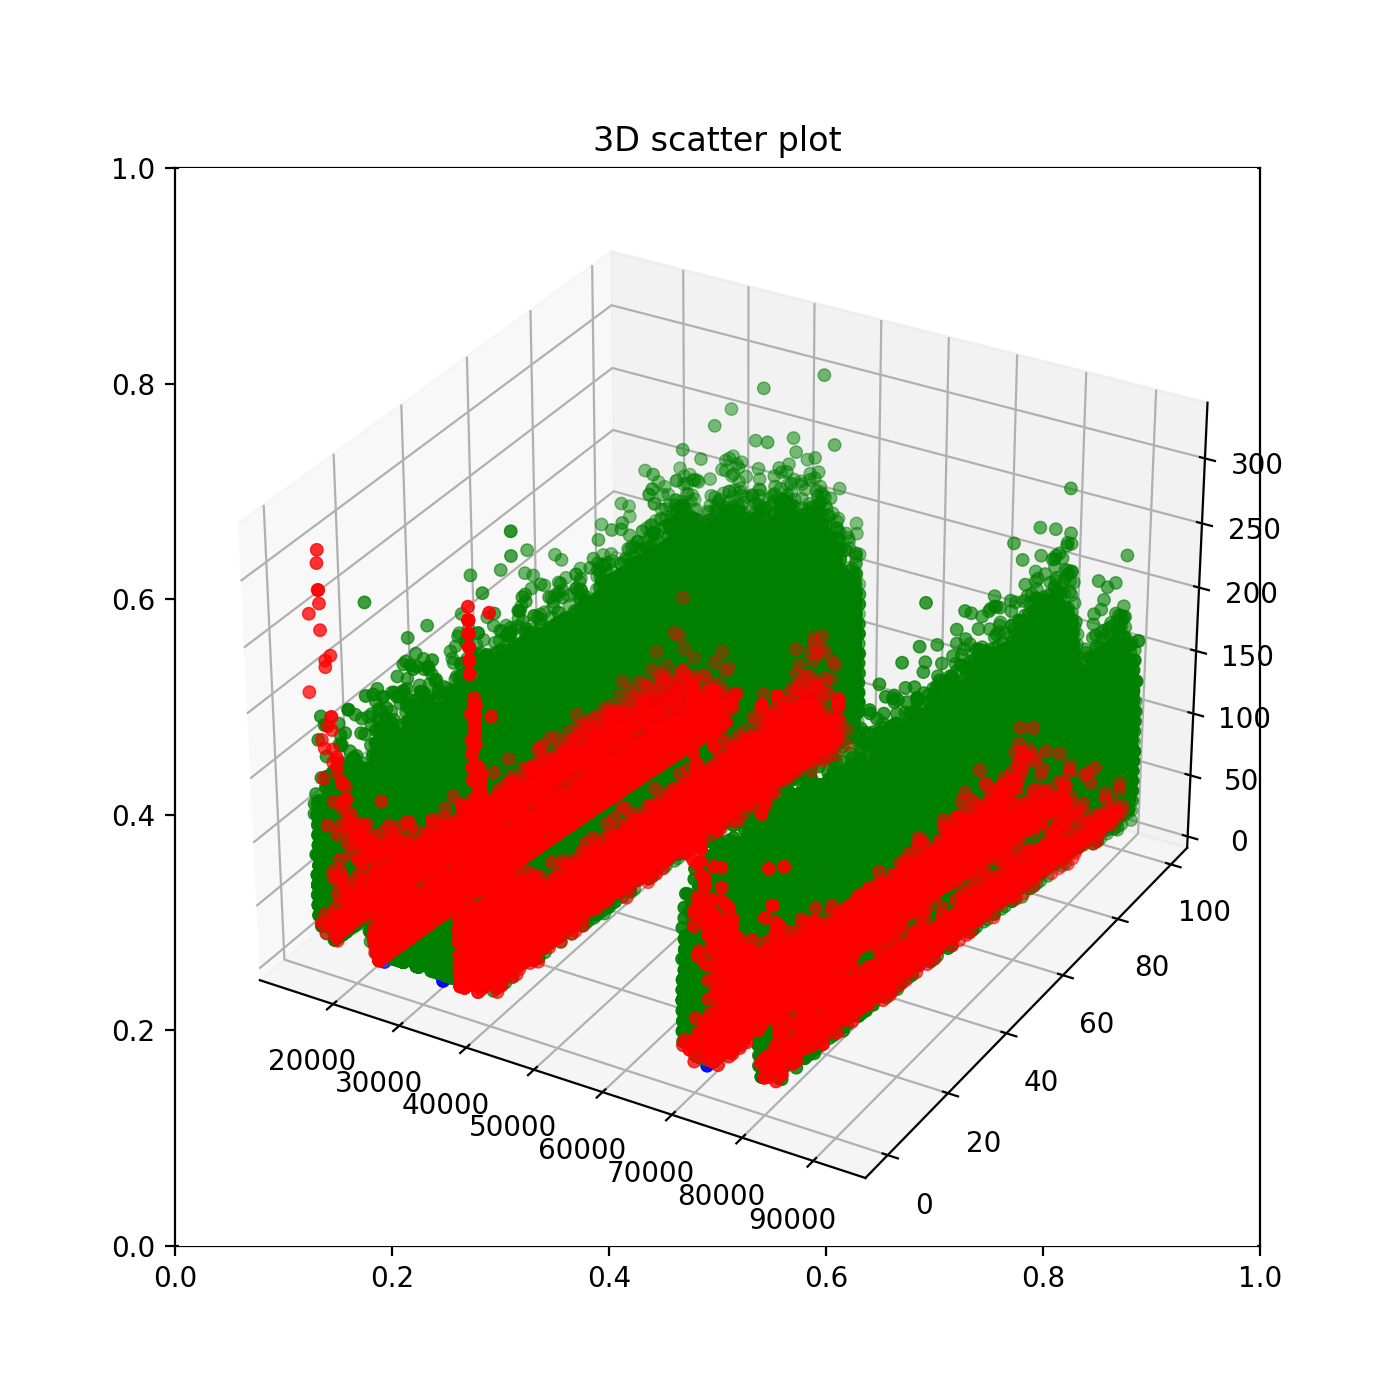

Text(0.5, 0.92, '3D scatter plot')

In [178]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1,1,1)

ax = plt.axes(projection='3d')
ax.scatter(axis1, z_par, z8_iter, ',',color='green', linewidth=0.5)

ax.scatter(axis1, z_par, z5_iter, ',',color='red', linewidth=0.5)
ax.scatter(axis1, z_par, z11_iter, ',',color='blue', linewidth=0.5)
plt.title('3D scatter plot')

In [194]:
sorted_index_11 = np.argsort(z11_iter)

sorted_11_axis1, sorted_11_z_par, sorted_11_z11_iter = np.zeros(len(z_par)),np.zeros(len(z_par)),np.zeros(len(z_par))
for i in range(len(z_par)):
    sorted_11_axis1[i] = axis1[sorted_index_11[i]]
    sorted_11_z_par[i] = z_par[sorted_index_11[i]]
    sorted_11_z11_iter[i] = z11_iter[sorted_index_11[i]]

In [196]:
sorted_index_8 = np.argsort(z8_iter)

sorted_8_axis1, sorted_8_z_par, sorted_8_z8_iter = np.zeros(len(z_par)),np.zeros(len(z_par)),np.zeros(len(z_par))
for i in range(len(z_par)):
    sorted_8_axis1[i] = axis1[sorted_index_8[i]]
    sorted_8_z_par[i] = z_par[sorted_index_8[i]]
    sorted_8_z8_iter[i] = z8_iter[sorted_index_8[i]]

In [198]:
sorted_index_5 = np.argsort(z5_iter)

sorted_5_axis1, sorted_5_z_par, sorted_5_z5_iter = np.zeros(len(z_par)),np.zeros(len(z_par)),np.zeros(len(z_par))
for i in range(len(z_par)):
    sorted_5_axis1[i] = axis1[sorted_index_5[i]]
    sorted_5_z_par[i] = z_par[sorted_index_5[i]]
    sorted_5_z5_iter[i] = z5_iter[sorted_index_5[i]]

<IPython.core.display.Javascript object>


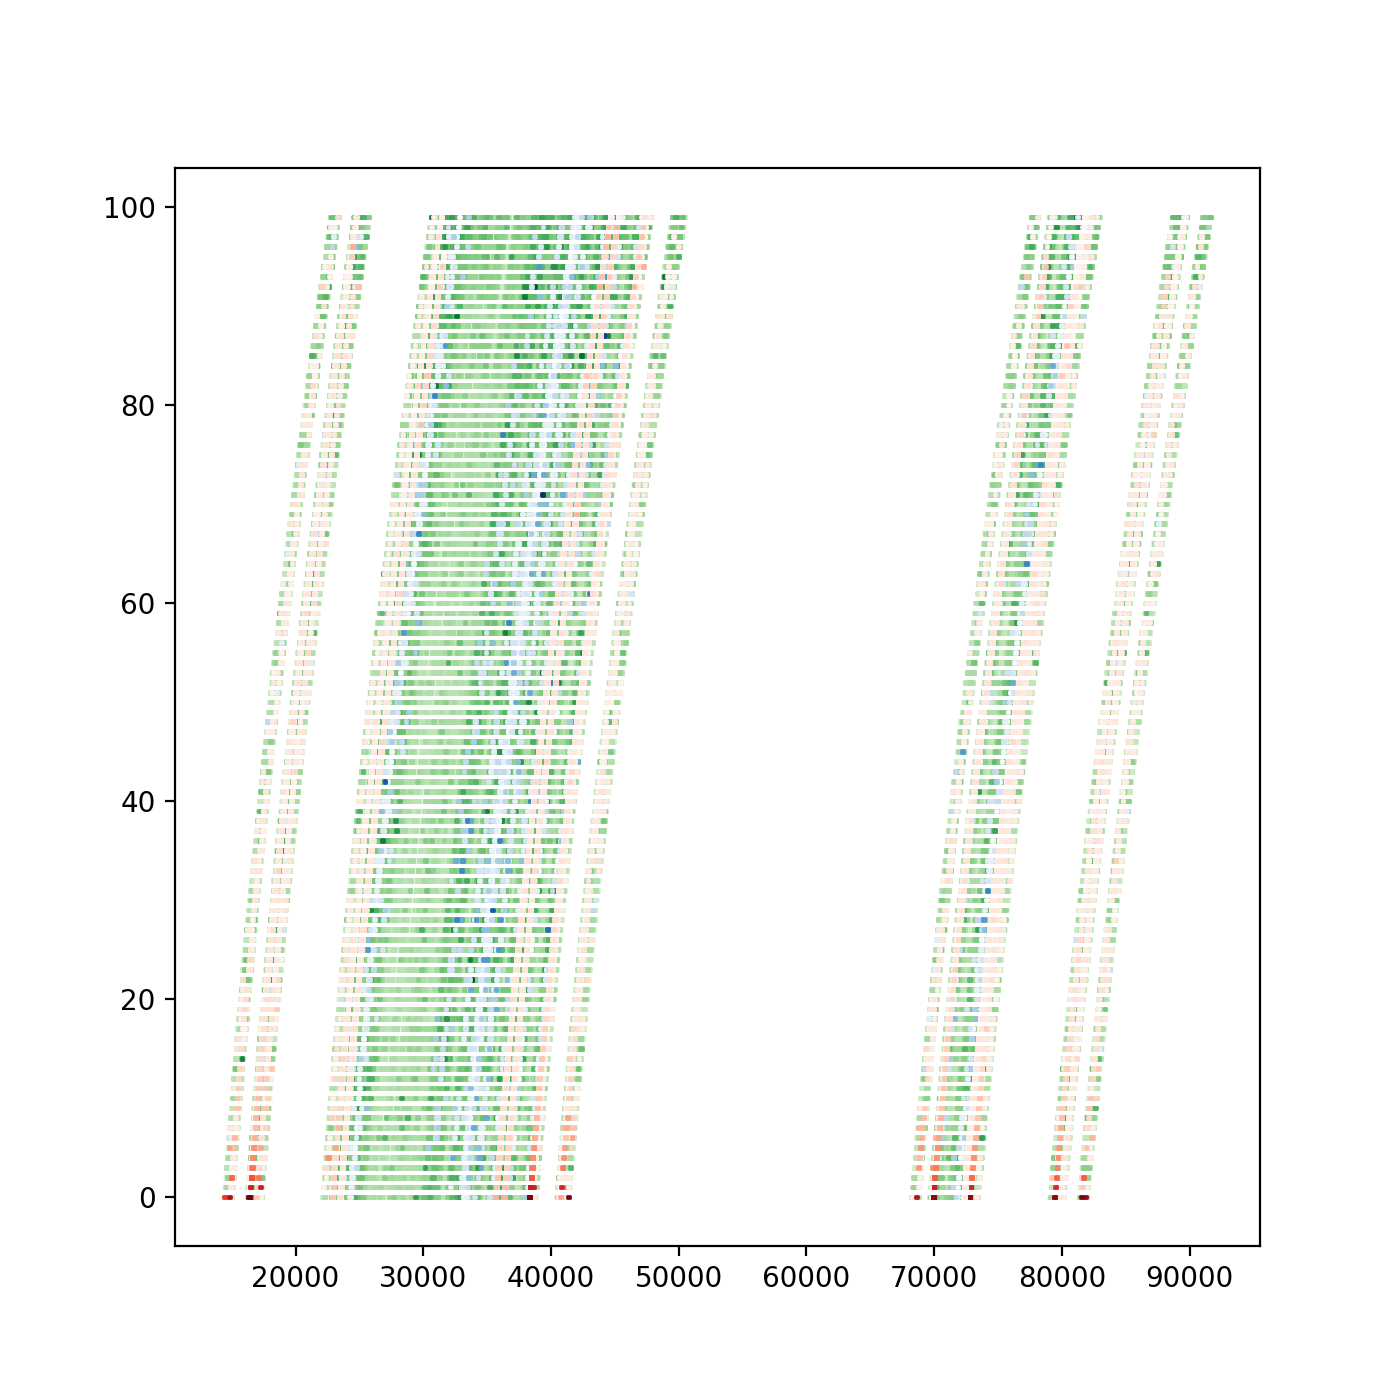

In [203]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1,1,1)
#ax.scatter(axis1, z_par, c = z8_iter,cmap = 'Greens',marker = ',')
ax.scatter(sorted_8_axis1, sorted_8_z_par, c = sorted_8_z8_iter, cmap = 'Greens', marker = ',', s = 1)

#ax.scatter(axis1, z_par, c = z11_iter,cmap = 'Blues',marker = '.')
ax.scatter(sorted_11_axis1, sorted_11_z_par, c = sorted_11_z11_iter, cmap = 'Blues', marker = ',', s = 1)

#ax.scatter(axis1, z_par, c = z5_iter,cmap = 'Reds',marker = ',')
ax.scatter(sorted_5_axis1, sorted_5_z_par, c = sorted_5_z5_iter, cmap = 'Reds', marker = ',', s = 1)

In [205]:
par_dens = 60
b_train = np.linspace(-0.436399,-0.430103,par_dens)
a_train = np.linspace(2.26115,2.2499,par_dens)


x_f_list = []
start = time.time()


x_bot_left =0.738513439884581
x_bot_right = 0.7387115686484647


x_top_left =0.7413734916322118
x_top_right = 0.7415680180549339

x_left = np.linspace(x_bot_left,x_top_left,par_dens)
x_right = np.linspace(x_bot_right,x_top_right,par_dens)

density = 50000

list_5_vals2 = np.zeros(par_dens)
list_8_vals2 = np.zeros(par_dens)
list_11_vals2 = np.zeros(par_dens)

# z_i = (L_i, iter_count_i, (b,a)_i) 
z_par = np.zeros(par_dens*density+1)

z5_Li = np.zeros(par_dens*density+1)
z5_iter = np.zeros(par_dens*density+1)


z8_Li = np.zeros(par_dens*density+1)
z8_iter = np.zeros(par_dens*density+1)

z11_Li = np.zeros(par_dens*density+1)
z11_iter = np.zeros(par_dens*density+1)

total_iteration_num = 0
for j in range(par_dens):
    
    
    myBasinData = get_basins_ofLine( a_train[j],b_train[j],[x_left[j],0],[x_right[j],0],density)
    
    
    

    #x_f_list.append(x_f_i)
    print(j,': ',(time.time()-start)/60,' min')


    basin11_data = myBasinData[2]
    basin11_x,basin11_y,basin11_iterCount = basin11_data[0],basin11_data[1],basin11_data[2]

    basin8_data = myBasinData[1]
    basin8_x,basin8_y,basin8_iterCount = basin8_data[0],basin8_data[1],basin8_data[2]

    basin5_data = myBasinData[0]
    basin5_x,basin5_y,basin5_iterCount = basin5_data[0],basin5_data[1],basin5_data[2]

    my_x_f = myBasinData[3]

    L_5_points,L_8_points,L_11_points = np.zeros(density),np.zeros(density),np.zeros(density)

    counter_5,counter_8,counter_11 = 0,0,0
    
    for i in range(density):
        total_iteration_num += 1
        
        z_par[total_iteration_num] = j
        

        if my_x_f[i] == 5:
            L_5_points[i] = basin5_iterCount[counter_5]
            
            z5_Li[total_iteration_num] = total_iteration_num
            z5_iter[total_iteration_num] = basin5_iterCount[counter_5]
            
            counter_5 += 1

        if my_x_f[i] == 8:
            L_8_points[i] = basin8_iterCount[counter_8]
            
            z8_Li[total_iteration_num] = total_iteration_num
            z8_iter[total_iteration_num] = basin8_iterCount[counter_8]
            
            counter_8 += 1    

        if my_x_f[i] == 11:
            L_11_points[i] = basin11_iterCount[counter_11]
            
            z11_Li[total_iteration_num] = total_iteration_num
            z11_iter[total_iteration_num] = basin11_iterCount[counter_11]
            
            counter_11 += 1 

    L_5_points[ L_5_points ==0 ] = np.nan
    L_8_points[ L_8_points ==0 ] = np.nan
    L_11_points[ L_11_points ==0 ] = np.nan
    
    



0.0
0.4
0.8
1.2
1.6
2.0
2.4
2.8000000000000003
3.2
3.5999999999999996
4.0
4.3999999999999995
4.8
5.2
5.6000000000000005
6.0
6.4
6.800000000000001
7.199999999999999
7.6
8.0
8.4
8.799999999999999
9.2
9.6
10.0
10.4
10.8
11.200000000000001
11.600000000000001
12.0
12.4
12.8
13.200000000000001
13.600000000000001
14.000000000000002
14.399999999999999
14.799999999999999
15.2
15.6
16.0
16.400000000000002
16.8
17.2
17.599999999999998
18.0
18.4
18.8
19.2
19.6
20.0
20.4
20.8
21.2
21.6
22.0
22.400000000000002
22.8
23.200000000000003
23.599999999999998
24.0
24.4
24.8
25.2
25.6
26.0
26.400000000000002
26.8
27.200000000000003
27.6
28.000000000000004
28.4
28.799999999999997
29.2
29.599999999999998
30.0
30.4
30.8
31.2
31.6
32.0
32.4
32.800000000000004
33.2
33.6
34.0
34.4
34.8
35.199999999999996
35.6
36.0
36.4
36.8
37.2
37.6
38.0
38.4
38.800000000000004
39.2
39.6
40.0
40.400000000000006
40.8
41.199999999999996
41.6
42.0
42.4
42.8
43.2
43.6
44.0
44.4
44.800000000000004
45.2
45.6
46.0
46.400000000000006
46

84.0
84.39999999999999
84.8
85.2
85.6
86.0
86.4
86.8
87.2
87.6
88.0
88.4
88.8
89.2
89.60000000000001
90.0
90.4
90.8
91.2
91.60000000000001
92.0
92.4
92.80000000000001
93.2
93.60000000000001
94.0
94.39999999999999
94.8
95.19999999999999
95.6
96.0
96.39999999999999
96.8
97.2
97.6
98.0
98.4
98.8
99.2
99.6
3 :  40.46646949847539  min
0.0
0.4
0.8
1.2
1.6
2.0
2.4
2.8000000000000003
3.2
3.5999999999999996
4.0
4.3999999999999995
4.8
5.2
5.6000000000000005
6.0
6.4
6.800000000000001
7.199999999999999
7.6
8.0
8.4
8.799999999999999
9.2
9.6
10.0
10.4
10.8
11.200000000000001
11.600000000000001
12.0
12.4
12.8
13.200000000000001
13.600000000000001
14.000000000000002
14.399999999999999
14.799999999999999
15.2
15.6
16.0
16.400000000000002
16.8
17.2
17.599999999999998
18.0
18.4
18.8
19.2
19.6
20.0
20.4
20.8
21.2
21.6
22.0
22.400000000000002
22.8
23.200000000000003
23.599999999999998
24.0
24.4
24.8
25.2
25.6
26.0
26.400000000000002
26.8
27.200000000000003
27.6
28.000000000000004
28.4
28.799999999999997
29

66.0
66.4
66.8
67.2
67.60000000000001
68.0
68.4
68.8
69.19999999999999
69.6
70.0
70.39999999999999
70.8
71.2
71.6
72.0
72.39999999999999
72.8
73.2
73.6
74.0
74.4
74.8
75.2
75.6
76.0
76.4
76.8
77.2
77.60000000000001
78.0
78.4
78.8
79.2
79.60000000000001
80.0
80.4
80.80000000000001
81.2
81.6
82.0
82.39999999999999
82.8
83.2
83.6
84.0
84.39999999999999
84.8
85.2
85.6
86.0
86.4
86.8
87.2
87.6
88.0
88.4
88.8
89.2
89.60000000000001
90.0
90.4
90.8
91.2
91.60000000000001
92.0
92.4
92.80000000000001
93.2
93.60000000000001
94.0
94.39999999999999
94.8
95.19999999999999
95.6
96.0
96.39999999999999
96.8
97.2
97.6
98.0
98.4
98.8
99.2
99.6
7 :  75.57829314867655  min
0.0
0.4
0.8
1.2
1.6
2.0
2.4
2.8000000000000003
3.2
3.5999999999999996
4.0
4.3999999999999995
4.8
5.2
5.6000000000000005
6.0
6.4
6.800000000000001
7.199999999999999
7.6
8.0
8.4
8.799999999999999
9.2
9.6
10.0
10.4
10.8
11.200000000000001
11.600000000000001
12.0
12.4
12.8
13.200000000000001
13.600000000000001
14.000000000000002
14.399999999

53.2
53.6
54.0
54.400000000000006
54.800000000000004
55.2
55.60000000000001
56.00000000000001
56.39999999999999
56.8
57.199999999999996
57.599999999999994
57.99999999999999
58.4
58.8
59.199999999999996
59.599999999999994
60.0
60.4
60.8
61.199999999999996
61.6
62.0
62.4
62.8
63.2
63.6
64.0
64.4
64.8
65.2
65.60000000000001
66.0
66.4
66.8
67.2
67.60000000000001
68.0
68.4
68.8
69.19999999999999
69.6
70.0
70.39999999999999
70.8
71.2
71.6
72.0
72.39999999999999
72.8
73.2
73.6
74.0
74.4
74.8
75.2
75.6
76.0
76.4
76.8
77.2
77.60000000000001
78.0
78.4
78.8
79.2
79.60000000000001
80.0
80.4
80.80000000000001
81.2
81.6
82.0
82.39999999999999
82.8
83.2
83.6
84.0
84.39999999999999
84.8
85.2
85.6
86.0
86.4
86.8
87.2
87.6
88.0
88.4
88.8
89.2
89.60000000000001
90.0
90.4
90.8
91.2
91.60000000000001
92.0
92.4
92.80000000000001
93.2
93.60000000000001
94.0
94.39999999999999
94.8
95.19999999999999
95.6
96.0
96.39999999999999
96.8
97.2
97.6
98.0
98.4
98.8
99.2
99.6
11 :  110.98291995127995  min
0.0
0.4
0.8
1.

37.2
37.6
38.0
38.4
38.800000000000004
39.2
39.6
40.0
40.400000000000006
40.8
41.199999999999996
41.6
42.0
42.4
42.8
43.2
43.6
44.0
44.4
44.800000000000004
45.2
45.6
46.0
46.400000000000006
46.800000000000004
47.199999999999996
47.599999999999994
48.0
48.4
48.8
49.2
49.6
50.0
50.4
50.8
51.2
51.6
52.0
52.400000000000006
52.800000000000004
53.2
53.6
54.0
54.400000000000006
54.800000000000004
55.2
55.60000000000001
56.00000000000001
56.39999999999999
56.8
57.199999999999996
57.599999999999994
57.99999999999999
58.4
58.8
59.199999999999996
59.599999999999994
60.0
60.4
60.8
61.199999999999996
61.6
62.0
62.4
62.8
63.2
63.6
64.0
64.4
64.8
65.2
65.60000000000001
66.0
66.4
66.8
67.2
67.60000000000001
68.0
68.4
68.8
69.19999999999999
69.6
70.0
70.39999999999999
70.8
71.2
71.6
72.0
72.39999999999999
72.8
73.2
73.6
74.0
74.4
74.8
75.2
75.6
76.0
76.4
76.8
77.2
77.60000000000001
78.0
78.4
78.8
79.2
79.60000000000001
80.0
80.4
80.80000000000001
81.2
81.6
82.0
82.39999999999999
82.8
83.2
83.6
84.0
84.

21.2
21.6
22.0
22.400000000000002
22.8
23.200000000000003
23.599999999999998
24.0
24.4
24.8
25.2
25.6
26.0
26.400000000000002
26.8
27.200000000000003
27.6
28.000000000000004
28.4
28.799999999999997
29.2
29.599999999999998
30.0
30.4
30.8
31.2
31.6
32.0
32.4
32.800000000000004
33.2
33.6
34.0
34.4
34.8
35.199999999999996
35.6
36.0
36.4
36.8
37.2
37.6
38.0
38.4
38.800000000000004
39.2
39.6
40.0
40.400000000000006
40.8
41.199999999999996
41.6
42.0
42.4
42.8
43.2
43.6
44.0
44.4
44.800000000000004
45.2
45.6
46.0
46.400000000000006
46.800000000000004
47.199999999999996
47.599999999999994
48.0
48.4
48.8
49.2
49.6
50.0
50.4
50.8
51.2
51.6
52.0
52.400000000000006
52.800000000000004
53.2
53.6
54.0
54.400000000000006
54.800000000000004
55.2
55.60000000000001
56.00000000000001
56.39999999999999
56.8
57.199999999999996
57.599999999999994
57.99999999999999
58.4
58.8
59.199999999999996
59.599999999999994
60.0
60.4
60.8
61.199999999999996
61.6
62.0
62.4
62.8
63.2
63.6
64.0
64.4
64.8
65.2
65.600000000000

6.800000000000001
7.199999999999999
7.6
8.0
8.4
8.799999999999999
9.2
9.6
10.0
10.4
10.8
11.200000000000001
11.600000000000001
12.0
12.4
12.8
13.200000000000001
13.600000000000001
14.000000000000002
14.399999999999999
14.799999999999999
15.2
15.6
16.0
16.400000000000002
16.8
17.2
17.599999999999998
18.0
18.4
18.8
19.2
19.6
20.0
20.4
20.8
21.2
21.6
22.0
22.400000000000002
22.8
23.200000000000003
23.599999999999998
24.0
24.4
24.8
25.2
25.6
26.0
26.400000000000002
26.8
27.200000000000003
27.6
28.000000000000004
28.4
28.799999999999997
29.2
29.599999999999998
30.0
30.4
30.8
31.2
31.6
32.0
32.4
32.800000000000004
33.2
33.6
34.0
34.4
34.8
35.199999999999996
35.6
36.0
36.4
36.8
37.2
37.6
38.0
38.4
38.800000000000004
39.2
39.6
40.0
40.400000000000006
40.8
41.199999999999996
41.6
42.0
42.4
42.8
43.2
43.6
44.0
44.4
44.800000000000004
45.2
45.6
46.0
46.400000000000006
46.800000000000004
47.199999999999996
47.599999999999994
48.0
48.4
48.8
49.2
49.6
50.0
50.4
50.8
51.2
51.6
52.0
52.400000000000006

91.60000000000001
92.0
92.4
92.80000000000001
93.2
93.60000000000001
94.0
94.39999999999999
94.8
95.19999999999999
95.6
96.0
96.39999999999999
96.8
97.2
97.6
98.0
98.4
98.8
99.2
99.6
26 :  246.01233077049255  min
0.0
0.4
0.8
1.2
1.6
2.0
2.4
2.8000000000000003
3.2
3.5999999999999996
4.0
4.3999999999999995
4.8
5.2
5.6000000000000005
6.0
6.4
6.800000000000001
7.199999999999999
7.6
8.0
8.4
8.799999999999999
9.2
9.6
10.0
10.4
10.8
11.200000000000001
11.600000000000001
12.0
12.4
12.8
13.200000000000001
13.600000000000001
14.000000000000002
14.399999999999999
14.799999999999999
15.2
15.6
16.0
16.400000000000002
16.8
17.2
17.599999999999998
18.0
18.4
18.8
19.2
19.6
20.0
20.4
20.8
21.2
21.6
22.0
22.400000000000002
22.8
23.200000000000003
23.599999999999998
24.0
24.4
24.8
25.2
25.6
26.0
26.400000000000002
26.8
27.200000000000003
27.6
28.000000000000004
28.4
28.799999999999997
29.2
29.599999999999998
30.0
30.4
30.8
31.2
31.6
32.0
32.4
32.800000000000004
33.2
33.6
34.0
34.4
34.8
35.199999999999996

71.6
72.0
72.39999999999999
72.8
73.2
73.6
74.0
74.4
74.8
75.2
75.6
76.0
76.4
76.8
77.2
77.60000000000001
78.0
78.4
78.8
79.2
79.60000000000001
80.0
80.4
80.80000000000001
81.2
81.6
82.0
82.39999999999999
82.8
83.2
83.6
84.0
84.39999999999999
84.8
85.2
85.6
86.0
86.4
86.8
87.2
87.6
88.0
88.4
88.8
89.2
89.60000000000001
90.0
90.4
90.8
91.2
91.60000000000001
92.0
92.4
92.80000000000001
93.2
93.60000000000001
94.0
94.39999999999999
94.8
95.19999999999999
95.6
96.0
96.39999999999999
96.8
97.2
97.6
98.0
98.4
98.8
99.2
99.6
30 :  295.1507725675901  min
0.0
0.4
0.8
1.2
1.6
2.0
2.4
2.8000000000000003
3.2
3.5999999999999996
4.0
4.3999999999999995
4.8
5.2
5.6000000000000005
6.0
6.4
6.800000000000001
7.199999999999999
7.6
8.0
8.4
8.799999999999999
9.2
9.6
10.0
10.4
10.8
11.200000000000001
11.600000000000001
12.0
12.4
12.8
13.200000000000001
13.600000000000001
14.000000000000002
14.399999999999999
14.799999999999999
15.2
15.6
16.0
16.400000000000002
16.8
17.2
17.599999999999998
18.0
18.4
18.8
19.2

56.39999999999999
56.8
57.199999999999996
57.599999999999994
57.99999999999999
58.4
58.8
59.199999999999996
59.599999999999994
60.0
60.4
60.8
61.199999999999996
61.6
62.0
62.4
62.8
63.2
63.6
64.0
64.4
64.8
65.2
65.60000000000001
66.0
66.4
66.8
67.2
67.60000000000001
68.0
68.4
68.8
69.19999999999999
69.6
70.0
70.39999999999999
70.8
71.2
71.6
72.0
72.39999999999999
72.8
73.2
73.6
74.0
74.4
74.8
75.2
75.6
76.0
76.4
76.8
77.2
77.60000000000001
78.0
78.4
78.8
79.2
79.60000000000001
80.0
80.4
80.80000000000001
81.2
81.6
82.0
82.39999999999999
82.8
83.2
83.6
84.0
84.39999999999999
84.8
85.2
85.6
86.0
86.4
86.8
87.2
87.6
88.0
88.4
88.8
89.2
89.60000000000001
90.0
90.4
90.8
91.2
91.60000000000001
92.0
92.4
92.80000000000001
93.2
93.60000000000001
94.0
94.39999999999999
94.8
95.19999999999999
95.6
96.0
96.39999999999999
96.8
97.2
97.6
98.0
98.4
98.8
99.2
99.6
34 :  330.4934759179751  min
0.0
0.4
0.8
1.2
1.6
2.0
2.4
2.8000000000000003
3.2
3.5999999999999996
4.0
4.3999999999999995
4.8
5.2
5.600000

41.6
42.0
42.4
42.8
43.2
43.6
44.0
44.4
44.800000000000004
45.2
45.6
46.0
46.400000000000006
46.800000000000004
47.199999999999996
47.599999999999994
48.0
48.4
48.8
49.2
49.6
50.0
50.4
50.8
51.2
51.6
52.0
52.400000000000006
52.800000000000004
53.2
53.6
54.0
54.400000000000006
54.800000000000004
55.2
55.60000000000001
56.00000000000001
56.39999999999999
56.8
57.199999999999996
57.599999999999994
57.99999999999999
58.4
58.8
59.199999999999996
59.599999999999994
60.0
60.4
60.8
61.199999999999996
61.6
62.0
62.4
62.8
63.2
63.6
64.0
64.4
64.8
65.2
65.60000000000001
66.0
66.4
66.8
67.2
67.60000000000001
68.0
68.4
68.8
69.19999999999999
69.6
70.0
70.39999999999999
70.8
71.2
71.6
72.0
72.39999999999999
72.8
73.2
73.6
74.0
74.4
74.8
75.2
75.6
76.0
76.4
76.8
77.2
77.60000000000001
78.0
78.4
78.8
79.2
79.60000000000001
80.0
80.4
80.80000000000001
81.2
81.6
82.0
82.39999999999999
82.8
83.2
83.6
84.0
84.39999999999999
84.8
85.2
85.6
86.0
86.4
86.8
87.2
87.6
88.0
88.4
88.8
89.2
89.60000000000001
90.0

25.6
26.0
26.400000000000002
26.8
27.200000000000003
27.6
28.000000000000004
28.4
28.799999999999997
29.2
29.599999999999998
30.0
30.4
30.8
31.2
31.6
32.0
32.4
32.800000000000004
33.2
33.6
34.0
34.4
34.8
35.199999999999996
35.6
36.0
36.4
36.8
37.2
37.6
38.0
38.4
38.800000000000004
39.2
39.6
40.0
40.400000000000006
40.8
41.199999999999996
41.6
42.0
42.4
42.8
43.2
43.6
44.0
44.4
44.800000000000004
45.2
45.6
46.0
46.400000000000006
46.800000000000004
47.199999999999996
47.599999999999994
48.0
48.4
48.8
49.2
49.6
50.0
50.4
50.8
51.2
51.6
52.0
52.400000000000006
52.800000000000004
53.2
53.6
54.0
54.400000000000006
54.800000000000004
55.2
55.60000000000001
56.00000000000001
56.39999999999999
56.8
57.199999999999996
57.599999999999994
57.99999999999999
58.4
58.8
59.199999999999996
59.599999999999994
60.0
60.4
60.8
61.199999999999996
61.6
62.0
62.4
62.8
63.2
63.6
64.0
64.4
64.8
65.2
65.60000000000001
66.0
66.4
66.8
67.2
67.60000000000001
68.0
68.4
68.8
69.19999999999999
69.6
70.0
70.3999999999

11.600000000000001
12.0
12.4
12.8
13.200000000000001
13.600000000000001
14.000000000000002
14.399999999999999
14.799999999999999
15.2
15.6
16.0
16.400000000000002
16.8
17.2
17.599999999999998
18.0
18.4
18.8
19.2
19.6
20.0
20.4
20.8
21.2
21.6
22.0
22.400000000000002
22.8
23.200000000000003
23.599999999999998
24.0
24.4
24.8
25.2
25.6
26.0
26.400000000000002
26.8
27.200000000000003
27.6
28.000000000000004
28.4
28.799999999999997
29.2
29.599999999999998
30.0
30.4
30.8
31.2
31.6
32.0
32.4
32.800000000000004
33.2
33.6
34.0
34.4
34.8
35.199999999999996
35.6
36.0
36.4
36.8
37.2
37.6
38.0
38.4
38.800000000000004
39.2
39.6
40.0
40.400000000000006
40.8
41.199999999999996
41.6
42.0
42.4
42.8
43.2
43.6
44.0
44.4
44.800000000000004
45.2
45.6
46.0
46.400000000000006
46.800000000000004
47.199999999999996
47.599999999999994
48.0
48.4
48.8
49.2
49.6
50.0
50.4
50.8
51.2
51.6
52.0
52.400000000000006
52.800000000000004
53.2
53.6
54.0
54.400000000000006
54.800000000000004
55.2
55.60000000000001
56.000000000

95.6
96.0
96.39999999999999
96.8
97.2
97.6
98.0
98.4
98.8
99.2
99.6
49 :  466.0305584669113  min
0.0
0.4
0.8
1.2
1.6
2.0
2.4
2.8000000000000003
3.2
3.5999999999999996
4.0
4.3999999999999995
4.8
5.2
5.6000000000000005
6.0
6.4
6.800000000000001
7.199999999999999
7.6
8.0
8.4
8.799999999999999
9.2
9.6
10.0
10.4
10.8
11.200000000000001
11.600000000000001
12.0
12.4
12.8
13.200000000000001
13.600000000000001
14.000000000000002
14.399999999999999
14.799999999999999
15.2
15.6
16.0
16.400000000000002
16.8
17.2
17.599999999999998
18.0
18.4
18.8
19.2
19.6
20.0
20.4
20.8
21.2
21.6
22.0
22.400000000000002
22.8
23.200000000000003
23.599999999999998
24.0
24.4
24.8
25.2
25.6
26.0
26.400000000000002
26.8
27.200000000000003
27.6
28.000000000000004
28.4
28.799999999999997
29.2
29.599999999999998
30.0
30.4
30.8
31.2
31.6
32.0
32.4
32.800000000000004
33.2
33.6
34.0
34.4
34.8
35.199999999999996
35.6
36.0
36.4
36.8
37.2
37.6
38.0
38.4
38.800000000000004
39.2
39.6
40.0
40.400000000000006
40.8
41.19999999999999

78.8
79.2
79.60000000000001
80.0
80.4
80.80000000000001
81.2
81.6
82.0
82.39999999999999
82.8
83.2
83.6
84.0
84.39999999999999
84.8
85.2
85.6
86.0
86.4
86.8
87.2
87.6
88.0
88.4
88.8
89.2
89.60000000000001
90.0
90.4
90.8
91.2
91.60000000000001
92.0
92.4
92.80000000000001
93.2
93.60000000000001
94.0
94.39999999999999
94.8
95.19999999999999
95.6
96.0
96.39999999999999
96.8
97.2
97.6
98.0
98.4
98.8
99.2
99.6
53 :  502.71038793325425  min
0.0
0.4
0.8
1.2
1.6
2.0
2.4
2.8000000000000003
3.2
3.5999999999999996
4.0
4.3999999999999995
4.8
5.2
5.6000000000000005
6.0
6.4
6.800000000000001
7.199999999999999
7.6
8.0
8.4
8.799999999999999
9.2
9.6
10.0
10.4
10.8
11.200000000000001
11.600000000000001
12.0
12.4
12.8
13.200000000000001
13.600000000000001
14.000000000000002
14.399999999999999
14.799999999999999
15.2
15.6
16.0
16.400000000000002
16.8
17.2
17.599999999999998
18.0
18.4
18.8
19.2
19.6
20.0
20.4
20.8
21.2
21.6
22.0
22.400000000000002
22.8
23.200000000000003
23.599999999999998
24.0
24.4
24.8
25

60.0
60.4
60.8
61.199999999999996
61.6
62.0
62.4
62.8
63.2
63.6
64.0
64.4
64.8
65.2
65.60000000000001
66.0
66.4
66.8
67.2
67.60000000000001
68.0
68.4
68.8
69.19999999999999
69.6
70.0
70.39999999999999
70.8
71.2
71.6
72.0
72.39999999999999
72.8
73.2
73.6
74.0
74.4
74.8
75.2
75.6
76.0
76.4
76.8
77.2
77.60000000000001
78.0
78.4
78.8
79.2
79.60000000000001
80.0
80.4
80.80000000000001
81.2
81.6
82.0
82.39999999999999
82.8
83.2
83.6
84.0
84.39999999999999
84.8
85.2
85.6
86.0
86.4
86.8
87.2
87.6
88.0
88.4
88.8
89.2
89.60000000000001
90.0
90.4
90.8
91.2
91.60000000000001
92.0
92.4
92.80000000000001
93.2
93.60000000000001
94.0
94.39999999999999
94.8
95.19999999999999
95.6
96.0
96.39999999999999
96.8
97.2
97.6
98.0
98.4
98.8
99.2
99.6
57 :  538.596406118075  min
0.0
0.4
0.8
1.2
1.6
2.0
2.4
2.8000000000000003
3.2
3.5999999999999996
4.0
4.3999999999999995
4.8
5.2
5.6000000000000005
6.0
6.4
6.800000000000001
7.199999999999999
7.6
8.0
8.4
8.799999999999999
9.2
9.6
10.0
10.4
10.8
11.200000000000001
1

In [206]:
print(len(range(density*par_dens)))
print(len(z_par))
print(len(z8_iter))

z5_iter[ z5_iter ==0 ] = np.nan
z8_iter[ z8_iter ==0 ] = np.nan
z11_iter[ z11_iter ==0 ] = np.nan

axis1 = np.zeros(density*par_dens+1)
for i in range(density*par_dens+1):
    axis1[i] = i%density

3000000
3000001
3000001


<IPython.core.display.Javascript object>


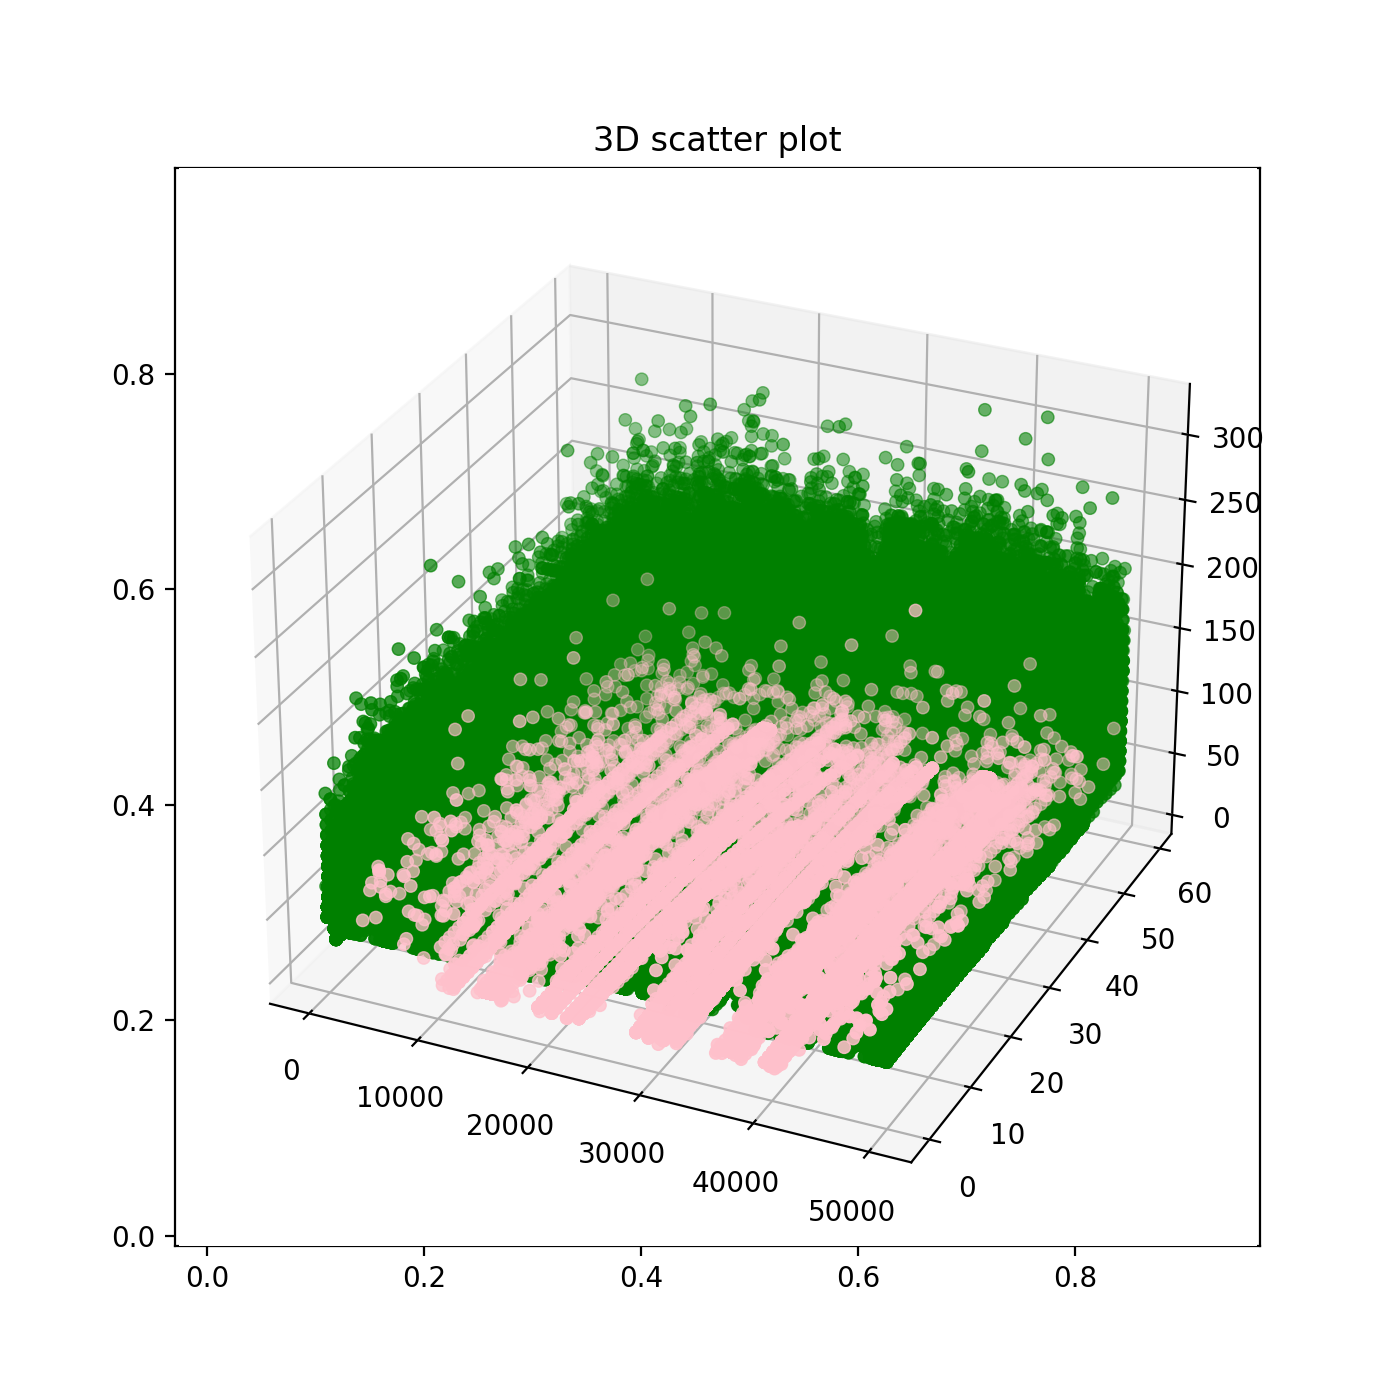

Text(0.5, 0.92, '3D scatter plot')

In [212]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1,1,1)

ax = plt.axes(projection='3d')
ax.scatter(axis1, z_par, z8_iter, ',',color='green', linewidth=0.5)

ax.scatter(axis1, z_par, z5_iter, ',',color='red', linewidth=0.5)
ax.scatter(axis1, z_par, z11_iter, ',',color='pink', linewidth=0.5)
plt.title('3D scatter plot')

In [210]:
sorted_index_11 = np.argsort(z11_iter)

sorted_11_axis1, sorted_11_z_par, sorted_11_z11_iter = np.zeros(len(z_par)),np.zeros(len(z_par)),np.zeros(len(z_par))
for i in range(len(z_par)):
    sorted_11_axis1[i] = axis1[sorted_index_11[i]]
    sorted_11_z_par[i] = z_par[sorted_index_11[i]]
    sorted_11_z11_iter[i] = z11_iter[sorted_index_11[i]]
sorted_index_8 = np.argsort(z8_iter)

sorted_8_axis1, sorted_8_z_par, sorted_8_z8_iter = np.zeros(len(z_par)),np.zeros(len(z_par)),np.zeros(len(z_par))
for i in range(len(z_par)):
    sorted_8_axis1[i] = axis1[sorted_index_8[i]]
    sorted_8_z_par[i] = z_par[sorted_index_8[i]]
    sorted_8_z8_iter[i] = z8_iter[sorted_index_8[i]]
sorted_index_5 = np.argsort(z5_iter)

sorted_5_axis1, sorted_5_z_par, sorted_5_z5_iter = np.zeros(len(z_par)),np.zeros(len(z_par)),np.zeros(len(z_par))
for i in range(len(z_par)):
    sorted_5_axis1[i] = axis1[sorted_index_5[i]]
    sorted_5_z_par[i] = z_par[sorted_index_5[i]]
    sorted_5_z5_iter[i] = z5_iter[sorted_index_5[i]]
    

<IPython.core.display.Javascript object>


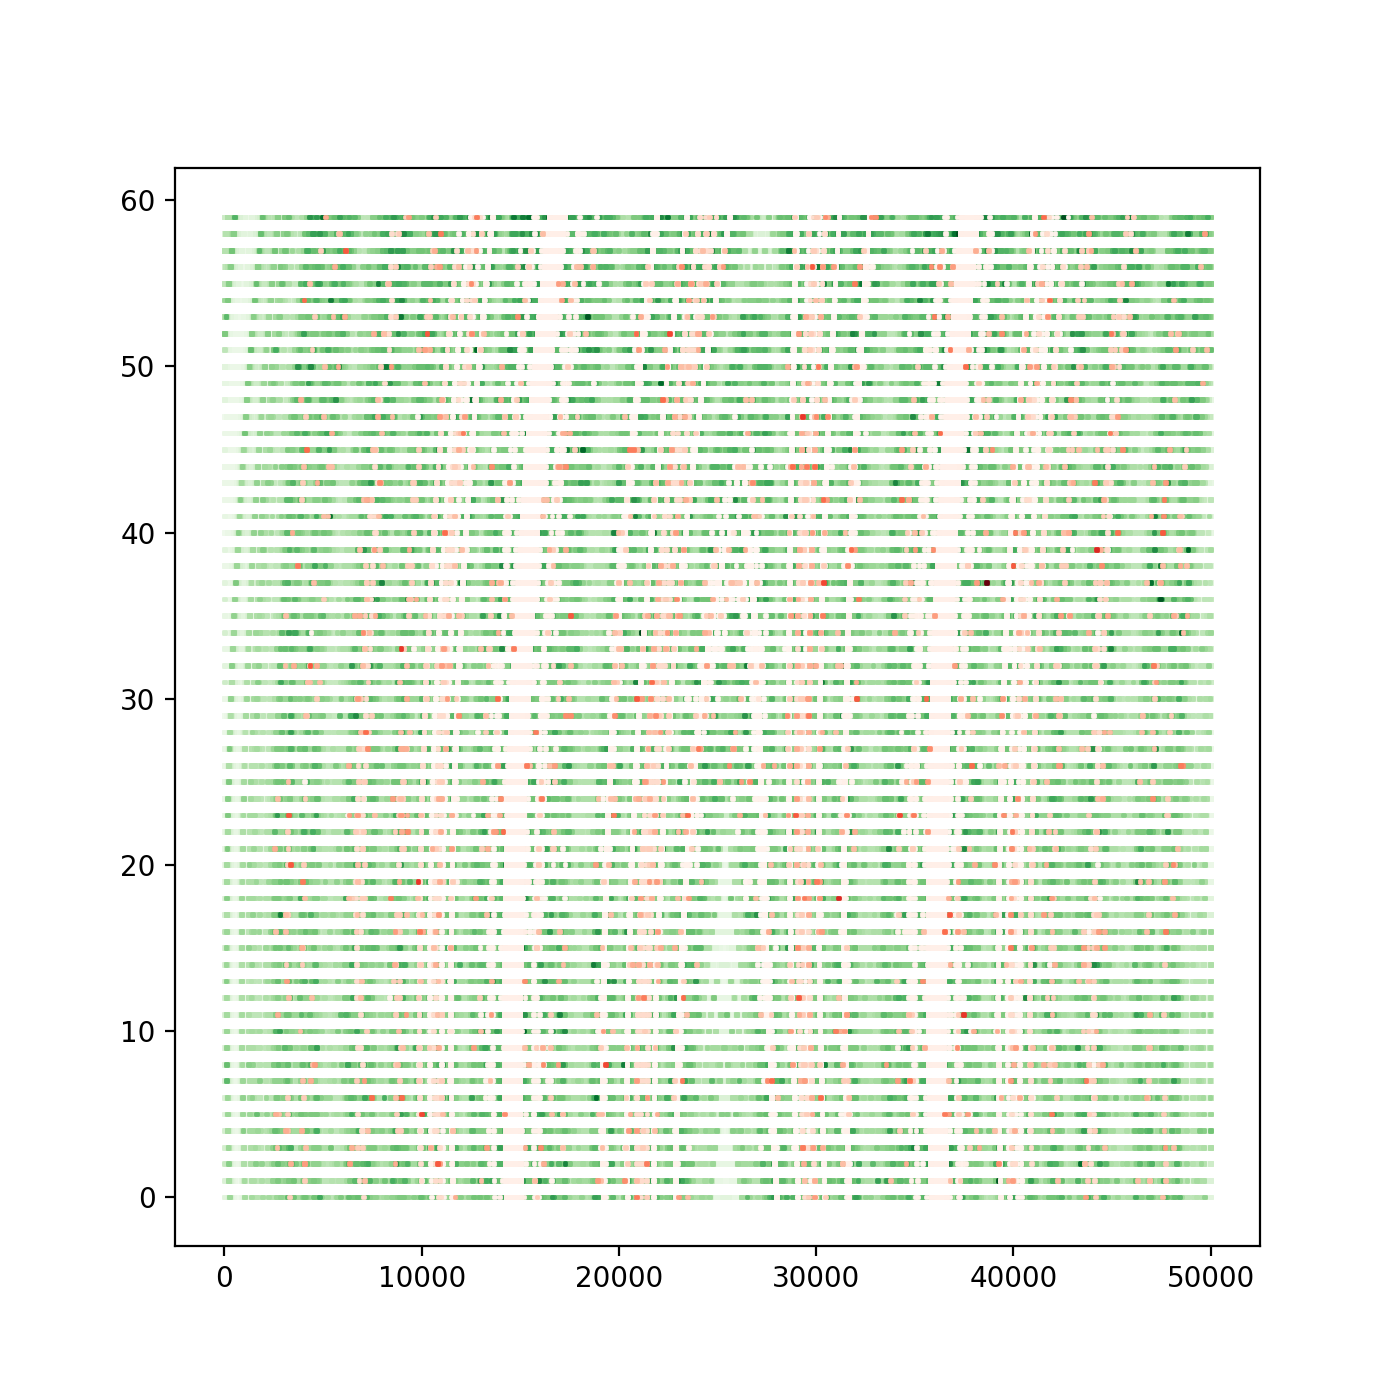

In [217]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1,1,1)
#ax.scatter(axis1, z_par, c = z8_iter,cmap = 'Greens',marker = ',')
ax.scatter(sorted_8_axis1, sorted_8_z_par, c = sorted_8_z8_iter, cmap = 'Greens', marker = ',', s = 1)

#ax.scatter(axis1, z_par, c = z11_iter,cmap = 'Blues',marker = '.')
ax.scatter(sorted_11_axis1, sorted_11_z_par, c = sorted_11_z11_iter, cmap = 'Reds', marker = ',', s = 1)

#ax.scatter(axis1, z_par, c = z5_iter,cmap = 'Reds',marker = ',')
ax.scatter(sorted_5_axis1, sorted_5_z_par, c = sorted_5_z5_iter, cmap = 'Reds', marker = ',', s = 1)

In [ ]:
par_dens = 100
b_train = np.linspace(-0.436399,-0.430103,par_dens)
a_train = np.linspace(2.26115,2.2499,par_dens)


x_f_list = []
start = time.time()


x_bot_left =0.7639930368652148
x_bot_right =0.764000242869017


x_top_left = 0.7670381739719476
x_top_right = 0.7670480822271757

x_left = np.linspace(x_bot_left,x_top_left,par_dens)
x_right = np.linspace(x_bot_right,x_top_right,par_dens)

density = 100000

list_5_vals2 = np.zeros(par_dens)
list_8_vals2 = np.zeros(par_dens)
list_11_vals2 = np.zeros(par_dens)

# z_i = (L_i, iter_count_i, (b,a)_i) 
z_par = np.zeros(par_dens*density+1)

z5_Li = np.zeros(par_dens*density+1)
z5_iter = np.zeros(par_dens*density+1)


z8_Li = np.zeros(par_dens*density+1)
z8_iter = np.zeros(par_dens*density+1)

z11_Li = np.zeros(par_dens*density+1)
z11_iter = np.zeros(par_dens*density+1)

total_iteration_num = 0
for j in range(par_dens):
    
    
    myBasinData = get_basins_ofLine( a_train[j],b_train[j],[x_left[j],0],[x_right[j],0],density)
    
    
    

    #x_f_list.append(x_f_i)
    print(j,': ',(time.time()-start)/60,' min')


    basin11_data = myBasinData[2]
    basin11_x,basin11_y,basin11_iterCount = basin11_data[0],basin11_data[1],basin11_data[2]

    basin8_data = myBasinData[1]
    basin8_x,basin8_y,basin8_iterCount = basin8_data[0],basin8_data[1],basin8_data[2]

    basin5_data = myBasinData[0]
    basin5_x,basin5_y,basin5_iterCount = basin5_data[0],basin5_data[1],basin5_data[2]

    my_x_f = myBasinData[3]

    L_5_points,L_8_points,L_11_points = np.zeros(density),np.zeros(density),np.zeros(density)

    counter_5,counter_8,counter_11 = 0,0,0
    
    for i in range(density):
        total_iteration_num += 1
        
        z_par[total_iteration_num] = j
        

        if my_x_f[i] == 5:
            L_5_points[i] = basin5_iterCount[counter_5]
            
            z5_Li[total_iteration_num] = total_iteration_num
            z5_iter[total_iteration_num] = basin5_iterCount[counter_5]
            
            counter_5 += 1

        if my_x_f[i] == 8:
            L_8_points[i] = basin8_iterCount[counter_8]
            
            z8_Li[total_iteration_num] = total_iteration_num
            z8_iter[total_iteration_num] = basin8_iterCount[counter_8]
            
            counter_8 += 1    

        if my_x_f[i] == 11:
            L_11_points[i] = basin11_iterCount[counter_11]
            
            z11_Li[total_iteration_num] = total_iteration_num
            z11_iter[total_iteration_num] = basin11_iterCount[counter_11]
            
            counter_11 += 1 

    L_5_points[ L_5_points ==0 ] = np.nan
    L_8_points[ L_8_points ==0 ] = np.nan
    L_11_points[ L_11_points ==0 ] = np.nan
    
    



0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.200000000000003
20.4
20.599999999999998
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.200000000000003
23.400000000000002
23

96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
1 :  25.335466567675272  min
0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.4
17.599999999999998
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20

92.60000000000001
92.80000000000001
93.0
93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.39999999999999
94.6
94.8
95.0
95.19999999999999
95.39999999999999
95.6
95.8
96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
3 :  49.41529413461685  min
0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.000000000000002
14.2
14.399999999999999
14.6
14.799999999999999

86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91.8
92.0
92.2
92.4
92.60000000000001
92.80000000000001
93.0
93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.39999999999999
94.6
94.8
95.0
95.19999999999999
95.39999999999999
95.6
95.8
96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
5 :  72.34736345211665  min
0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000

82.6
82.8
83.0
83.2
83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91.8
92.0
92.2
92.4
92.60000000000001
92.80000000000001
93.0
93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.39999999999999
94.6
94.8
95.0
95.19999999999999
95.39999999999999
95.6
95.8
96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
7 :  94.15196583271026  min
0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3

79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000000000001
80.80000000000001
81.0
81.2
81.39999999999999
81.6
81.8
82.0
82.19999999999999
82.39999999999999
82.6
82.8
83.0
83.2
83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91.8
92.0
92.2
92.4
92.60000000000001
92.80000000000001
93.0
93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.39999999999999
94.6
94.8
95.0
95.19999999999999
95.39999999999999
95.6
95.8
96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
9 :  114.65846923589706  min
0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4

72.6
72.8
73.0
73.2
73.4
73.6
73.8
74.0
74.2
74.4
74.6
74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0
77.2
77.4
77.60000000000001
77.8
78.0
78.2
78.4
78.60000000000001
78.8
79.0
79.2
79.4
79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000000000001
80.80000000000001
81.0
81.2
81.39999999999999
81.6
81.8
82.0
82.19999999999999
82.39999999999999
82.6
82.8
83.0
83.2
83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91.8
92.0
92.2
92.4
92.60000000000001
92.80000000000001
93.0
93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.39999999999999
94.6
94.8
95.0
95.19999999999999
95.39999999999999
95.6
95.8
96.0
96.2
96.39999999999999
96.6
96.8
97.0
97.2
97.39999999999999
97.6
97.8
98.0
98.2
98.4
98.6
98.8
99.0
99.2
99.4
99.6
99.8
11 

69.19999999999999
69.39999999999999
69.6
69.8
70.0
70.19999999999999
70.39999999999999
70.6
70.8
71.0
71.2
71.39999999999999
71.6
71.8
72.0
72.2
72.39999999999999
72.6
72.8
73.0
73.2
73.4
73.6
73.8
74.0
74.2
74.4
74.6
74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0
77.2
77.4
77.60000000000001
77.8
78.0
78.2
78.4
78.60000000000001
78.8
79.0
79.2
79.4
79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000000000001
80.80000000000001
81.0
81.2
81.39999999999999
81.6
81.8
82.0
82.19999999999999
82.39999999999999
82.6
82.8
83.0
83.2
83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.60000000000001
91.8
92.0
92.2
92.4
92.60000000000001
92.80000000000001
93.0
93.2
93.4
93.60000000000001
93.8
94.0
94.19999999999999
94.39999999999999
94.6
94.8
95.0
95.199999999

65.0
65.2
65.4
65.60000000000001
65.8
66.0
66.2
66.4
66.60000000000001
66.8
67.0
67.2
67.4
67.60000000000001
67.80000000000001
68.0
68.2
68.4
68.60000000000001
68.8
69.0
69.19999999999999
69.39999999999999
69.6
69.8
70.0
70.19999999999999
70.39999999999999
70.6
70.8
71.0
71.2
71.39999999999999
71.6
71.8
72.0
72.2
72.39999999999999
72.6
72.8
73.0
73.2
73.4
73.6
73.8
74.0
74.2
74.4
74.6
74.8
75.0
75.2
75.4
75.6
75.8
76.0
76.2
76.4
76.6
76.8
77.0
77.2
77.4
77.60000000000001
77.8
78.0
78.2
78.4
78.60000000000001
78.8
79.0
79.2
79.4
79.60000000000001
79.80000000000001
80.0
80.2
80.4
80.60000000000001
80.80000000000001
81.0
81.2
81.39999999999999
81.6
81.8
82.0
82.19999999999999
82.39999999999999
82.6
82.8
83.0
83.2
83.39999999999999
83.6
83.8
84.0
84.2
84.39999999999999
84.6
84.8
85.0
85.2
85.39999999999999
85.6
85.8
86.0
86.2
86.4
86.6
86.8
87.0
87.2
87.4
87.6
87.8
88.0
88.2
88.4
88.6
88.8
89.0
89.2
89.4
89.60000000000001
89.8
90.0
90.2
90.4
90.60000000000001
90.8
91.0
91.2
91.4
91.6000000